<a href="https://colab.research.google.com/github/Adal-Jurado/prueba/blob/main/SSH_NH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pylab import *

In [ ]:
from __future__ import print_function

# PythTB python tight binding module.
# September 20th, 2022
__version__='1.8.0'

# Copyright 2010, 2012, 2016, 2017, 2022 by Sinisa Coh and David Vanderbilt
#
# This file is part of PythTB.  PythTB is free software: you can
# redistribute it and/or modify it under the terms of the GNU General
# Public License as published by the Free Software Foundation, either
# version 3 of the License, or (at your option) any later version.
#
# PythTB is distributed in the hope that it will be useful, but WITHOUT
# ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
# or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public
# License for more details.
#
# A copy of the GNU General Public License should be available
# alongside this source in a file named gpl-3.0.txt.  If not,
# see <http://www.gnu.org/licenses/>.
#
# PythTB is availabe at http://www.physics.rutgers.edu/pythtb/

import numpy as np # numerics for matrices
import sys # for exiting
import copy # for deepcopying

class tb_model(object):
    r"""
    This is the main class of the PythTB package which contains all
    information for the tight-binding model.

    :param dim_k: Dimensionality of reciprocal space, i.e., specifies how
      many directions are considered to be periodic.

    :param dim_r: Dimensionality of real space, i.e., specifies how many
      real space lattice vectors there are and how many coordinates are
      needed to specify the orbital coordinates.

    .. note::

      Parameter *dim_r* can be larger than *dim_k*! For example,
      a polymer is a three-dimensional molecule (one needs three
      coordinates to specify orbital positions), but it is periodic
      along only one direction. For a polymer, therefore, we should
      have *dim_k* equal to 1 and *dim_r* equal to 3. See similar example
      here: :ref:`trestle-example`.

    :param lat: Array containing lattice vectors in Cartesian
      coordinates (in arbitrary units). In example the below, the first
      lattice vector has coordinates [1.0,0.5] while the second
      one has coordinates [0.0,2.0].  By default, lattice vectors
      are an identity matrix.

    :param orb: Array containing reduced coordinates of all
      tight-binding orbitals. In the example below, the first
      orbital is defined with reduced coordinates [0.2,0.3]. Its
      Cartesian coordinates are therefore 0.2 times the first
      lattice vector plus 0.3 times the second lattice vector.
      If *orb* is an integer code will assume that there are these many
      orbitals all at the origin of the unit cell.  By default
      the code will assume a single orbital at the origin.

    :param per: This is an optional parameter giving a list of lattice
      vectors which are considered to be periodic. In the example below,
      only the vector [0.0,2.0] is considered to be periodic (since
      per=[1]). By default, all lattice vectors are assumed to be
      periodic. If dim_k is smaller than dim_r, then by default the first
      dim_k vectors are considered to be periodic.

    :param nspin: Number of explicit spin components assumed for each
      orbital in *orb*. Allowed values of *nspin* are *1* and *2*. If
      *nspin* is 1 then the model is spinless, if *nspin* is 2 then it
      is explicitly a spinfull model and each orbital is assumed to
      have two spin components. Default value of this parameter is
      *1*.  Of course one can make spinfull calculation even with
      *nspin* set to 1, but then the user must keep track of which
      orbital corresponds to which spin component.

    Example usage::

       # Creates model that is two-dimensional in real space but only
       # one-dimensional in reciprocal space. Second lattice vector is
       # chosen to be periodic (since per=[1]). Three orbital
       # coordinates are specified.
       tb = tb_model(1, 2,
                   lat=[[1.0, 0.5], [0.0, 2.0]],
                   orb=[[0.2, 0.3], [0.1, 0.1], [0.2, 0.2]],
                   per=[1])

    """

    def __init__(self,dim_k,dim_r,lat=None,orb=None,per=None,nspin=1):

        # initialize _dim_k = dimensionality of k-space (integer)
        if not _is_int(dim_k):
            raise Exception("\n\nArgument dim_k not an integer")
        if dim_k < 0 or dim_k > 4:
            raise Exception("\n\nArgument dim_k out of range. Must be between 0 and 4.")
        self._dim_k=dim_k

        # initialize _dim_r = dimensionality of r-space (integer)
        if not _is_int(dim_r):
            raise Exception("\n\nArgument dim_r not an integer")
        if dim_r < dim_k or dim_r > 4:
            raise Exception("\n\nArgument dim_r out of range. Must be dim_r>=dim_k and dim_r<=4.")
        self._dim_r=dim_r

        # initialize _lat = lattice vectors, array of dim_r*dim_r
        #   format is _lat(lat_vec_index,cartesian_index)
        # special option: 'unit' implies unit matrix, also default value
        if (type(lat) is str and lat == 'unit') or lat is None:
            self._lat=np.identity(dim_r,float)
            print(" Lattice vectors not specified! I will use identity matrix.")
        else:
            self._lat=np.array(lat,dtype=float)
            if self._lat.shape!=(dim_r,dim_r):
                raise Exception("\n\nWrong lat array dimensions")
        # check that volume is not zero and that have right handed system
        if dim_r>0:
            if np.abs(np.linalg.det(self._lat))<1.0E-6:
                raise Exception("\n\nLattice vectors length/area/volume too close to zero, or zero.")
            if np.linalg.det(self._lat)<0.0:
                raise Exception("\n\nLattice vectors need to form right handed system.")

        # initialize _norb = number of basis orbitals per cell
        #   and       _orb = orbital locations, in reduced coordinates
        #   format is _orb(orb_index,lat_vec_index)
        # special option: 'bravais' implies one atom at origin
        if (type(orb) is str and orb == 'bravais') or orb is None:
            self._norb=1
            self._orb=np.zeros((1,dim_r))
            print(" Orbital positions not specified. I will assume a single orbital at the origin.")
        elif _is_int(orb):
            self._norb=orb
            self._orb=np.zeros((orb,dim_r))
            print(" Orbital positions not specified. I will assume ",orb," orbitals at the origin")
        else:
            self._orb=np.array(orb,dtype=float)
            if len(self._orb.shape)!=2:
                raise Exception("\n\nWrong orb array rank")
            self._norb=self._orb.shape[0] # number of orbitals
            if self._orb.shape[1]!=dim_r:
                raise Exception("\n\nWrong orb array dimensions")

        # choose which self._dim_k out of self._dim_r dimensions are
        # to be considered periodic.
        if per is None:
            # by default first _dim_k dimensions are periodic
            self._per=list(range(self._dim_k))
        else:
            if len(per)!=self._dim_k:
                raise Exception("\n\nWrong choice of periodic/infinite direction!")
            # store which directions are the periodic ones
            self._per=per

        # remember number of spin components
        if nspin not in [1,2]:
            raise Exception("\n\nWrong value of nspin, must be 1 or 2!")
        self._nspin=nspin

        # by default, assume model did not come from w90 object and that
        # position operator is diagonal
        self._assume_position_operator_diagonal=True

        # compute number of electronic states at each k-point
        self._nsta=self._norb*self._nspin

        # Initialize onsite energies to zero
        if self._nspin==1:
            self._site_energies=np.zeros((self._norb),dtype=complex) ####
        elif self._nspin==2:
            self._site_energies=np.zeros((self._norb,2,2),dtype=complex)
        # remember which onsite energies user has specified
        self._site_energies_specified=np.zeros(self._norb,dtype=bool)
        self._site_energies_specified[:]=False

        # Initialize hoppings to empty list
        self._hoppings=[]

        # The onsite energies and hoppings are not specified
        # when creating a 'tb_model' object.  They are speficied
        # subsequently by separate function calls defined below.

    def set_onsite(self,onsite_en,ind_i=None,mode="set"):
        r"""
        Defines on-site energies for tight-binding orbitals. One can
        either set energy for one tight-binding orbital, or all at
        once.

        :param onsite_en: Either a list of on-site energies (in
          arbitrary units) for each orbital, or a single on-site
          energy (in this case *ind_i* parameter must be given). In
          the case when *nspin* is *1* (spinless) then each on-site
          energy is a single number.  If *nspin* is *2* then on-site
          energy can be given either as a single number, or as an
          array of four numbers, or 2x2 matrix. If a single number is
          given, it is interpreted as on-site energy for both up and
          down spin component. If an array of four numbers is given,
          these are the coefficients of I, sigma_x, sigma_y, and
          sigma_z (that is, the 2x2 identity and the three Pauli spin
          matrices) respectively. Finally, full 2x2 matrix can be
          given as well. If this function is never called, on-site
          energy is assumed to be zero.

        :param ind_i: Index of tight-binding orbital whose on-site
          energy you wish to change. This parameter should be
          specified only when *onsite_en* is a single number (not a
          list).

        :param mode: Similar to parameter *mode* in function set_hop*.
          Speficies way in which parameter *onsite_en* is
          used. It can either set value of on-site energy from scratch,
          reset it, or add to it.

          * "set" -- Default value. On-site energy is set to value of
            *onsite_en* parameter. One can use "set" on each
            tight-binding orbital only once.

          * "reset" -- Specifies on-site energy to given value. This
            function can be called multiple times for the same
            orbital(s).

          * "add" -- Adds to the previous value of on-site
            energy. This function can be called multiple times for the
            same orbital(s).

        Example usage::

          # Defines on-site energy of first orbital to be 0.0,
          # second 1.0, and third 2.0
          tb.set_onsite([0.0, 1.0, 2.0])
          # Increases value of on-site energy for second orbital
          tb.set_onsite(100.0, 1, mode="add")
          # Changes on-site energy of second orbital to zero
          tb.set_onsite(0.0, 1, mode="reset")
          # Sets all three on-site energies at once
          tb.set_onsite([2.0, 3.0, 4.0], mode="reset")

        """
        if ind_i is None:
            if (len(onsite_en)!=self._norb):
                raise Exception("\n\nWrong number of site energies")
        # make sure ind_i is not out of scope
        if ind_i!=None:
            if ind_i<0 or ind_i>=self._norb:
                raise Exception("\n\nIndex ind_i out of scope.")
        # make sure that onsite terms are real/hermitian
        if ind_i!=None:
            to_check=[onsite_en]
        else:
            to_check=onsite_en
        for ons in to_check:
            if np.array(ons).shape==():
                pass
                #### if np.abs(np.array(ons)-np.array(ons).conjugate())>1.0E-8:
                    #### raise Exception("\n\nOnsite energy should not have imaginary part!")
            elif np.array(ons).shape==(4,):
                if np.max(np.abs(np.array(ons)-np.array(ons).conjugate()))>1.0E-8:
                    raise Exception("\n\nOnsite energy or Zeeman field should not have imaginary part!")
            elif np.array(ons).shape==(2,2):
                if np.max(np.abs(np.array(ons)-np.array(ons).T.conjugate()))>1.0E-8:
                    raise Exception("\n\nOnsite matrix should be Hermitian!")
        # specifying onsite energies from scratch, can be called only once
        if mode.lower()=="set":
            # specifying only one site at a time
            if ind_i!=None:
                # make sure we specify things only once
                if self._site_energies_specified[ind_i]==True:
                    raise Exception("\n\nOnsite energy for this site was already specified! Use mode=\"reset\" or mode=\"add\".")
                else:
                    self._site_energies[ind_i]=self._val_to_block(onsite_en)
                    self._site_energies_specified[ind_i]=True
            # specifying all sites at once
            else:
                # make sure we specify things only once
                if True in self._site_energies_specified[ind_i]:
                    raise Exception("\n\nSome or all onsite energies were already specified! Use mode=\"reset\" or mode=\"add\".")
                else:
                    for i in range(self._norb):
                        self._site_energies[i]=self._val_to_block(onsite_en[i])
                    self._site_energies_specified[:]=True
        # reset values of onsite terms, without adding to previous value
        elif mode.lower()=="reset":
            # specifying only one site at a time
            if ind_i!=None:
                self._site_energies[ind_i]=self._val_to_block(onsite_en)
                self._site_energies_specified[ind_i]=True
            # specifying all sites at once
            else:
                for i in range(self._norb):
                    self._site_energies[i]=self._val_to_block(onsite_en[i])
                self._site_energies_specified[:]=True
        # add to previous value
        elif mode.lower()=="add":
            # specifying only one site at a time
            if ind_i!=None:
                self._site_energies[ind_i]+=self._val_to_block(onsite_en)
                self._site_energies_specified[ind_i]=True
            # specifying all sites at once
            else:
                for i in range(self._norb):
                    self._site_energies[i]+=self._val_to_block(onsite_en[i])
                self._site_energies_specified[:]=True
        else:
            raise Exception("\n\nWrong value of mode parameter")

    def set_hop(self,hop_amp,ind_i,ind_j,ind_R=None,mode="set",allow_conjugate_pair=False):
        r"""

        Defines hopping parameters between tight-binding orbitals. In
        the notation used in section 3.1 equation 3.6 of
        :download:`notes on tight-binding formalism
        <misc/pythtb-formalism.pdf>` this function specifies the
        following object

        .. math::

          H_{ij}({\bf R})= \langle \phi_{{\bf 0} i}  \vert H  \vert \phi_{{\bf R},j} \rangle

        Where :math:`\langle \phi_{{\bf 0} i} \vert` is i-th
        tight-binding orbital in the home unit cell and
        :math:`\vert \phi_{{\bf R},j} \rangle` is j-th tight-binding orbital in
        unit cell shifted by lattice vector :math:`{\bf R}`. :math:`H`
        is the Hamiltonian.

        (Strictly speaking, this term specifies hopping amplitude
        for hopping from site *j+R* to site *i*, not vice-versa.)

        Hopping in the opposite direction is automatically included by
        the code since

        .. math::

          H_{ji}(-{\bf R})= \left[ H_{ij}({\bf R}) \right]^{*}

        .. warning::

           There is no need to specify hoppings in both :math:`i
           \rightarrow j+R` direction and opposite :math:`j
           \rightarrow i-R` direction since that is done
           automatically. If you want to specifiy hoppings in both
           directions, see description of parameter
           *allow_conjugate_pair*.

        :param hop_amp: Hopping amplitude; can be real or complex
          number, equals :math:`H_{ij}({\bf R})`. If *nspin* is *2*
          then hopping amplitude can be given either as a single
          number, or as an array of four numbers, or as 2x2 matrix. If
          a single number is given, it is interpreted as hopping
          amplitude for both up and down spin component.  If an array
          of four numbers is given, these are the coefficients of I,
          sigma_x, sigma_y, and sigma_z (that is, the 2x2 identity and
          the three Pauli spin matrices) respectively. Finally, full
          2x2 matrix can be given as well.

        :param ind_i: Index of bra orbital from the bracket :math:`\langle
          \phi_{{\bf 0} i} \vert H \vert \phi_{{\bf R},j} \rangle`. This
          orbital is assumed to be in the home unit cell.

        :param ind_j: Index of ket orbital from the bracket :math:`\langle
          \phi_{{\bf 0} i} \vert H \vert \phi_{{\bf R},j} \rangle`. This
          orbital does not have to be in the home unit cell; its unit cell
          position is determined by parameter *ind_R*.

        :param ind_R: Lattice vector (integer array, in reduced
          coordinates) pointing to the unit cell where the ket
          orbital is located.  The number of coordinates must equal
          the dimensionality in real space (*dim_r* parameter) for
          consistency, but only the periodic directions of ind_R are
          used. If reciprocal space is zero-dimensional (as in a
          molecule), this parameter does not need to be specified.

        :param mode: Similar to parameter *mode* in function *set_onsite*.
          Speficies way in which parameter *hop_amp* is
          used. It can either set value of hopping term from scratch,
          reset it, or add to it.

          * "set" -- Default value. Hopping term is set to value of
            *hop_amp* parameter. One can use "set" for each triplet of
            *ind_i*, *ind_j*, *ind_R* only once.

          * "reset" -- Specifies on-site energy to given value. This
            function can be called multiple times for the same triplet
            *ind_i*, *ind_j*, *ind_R*.

          * "add" -- Adds to the previous value of hopping term This
            function can be called multiple times for the same triplet
            *ind_i*, *ind_j*, *ind_R*.

          If *set_hop* was ever called with *allow_conjugate_pair* set
          to True, then it is possible that user has specified both
          :math:`i \rightarrow j+R` and conjugate pair :math:`j
          \rightarrow i-R`.  In this case, "set", "reset", and "add"
          parameters will treat triplet *ind_i*, *ind_j*, *ind_R* and
          conjugate triplet *ind_j*, *ind_i*, *-ind_R* as distinct.

        :param allow_conjugate_pair: Default value is *False*. If set
          to *True* code will allow user to specify hopping
          :math:`i \rightarrow j+R` even if conjugate-pair hopping
          :math:`j \rightarrow i-R` has been
          specified. If both terms are specified, code will
          still count each term two times.

        Example usage::

          # Specifies complex hopping amplitude between first orbital in home
          # unit cell and third orbital in neigbouring unit cell.
          tb.set_hop(0.3+0.4j, 0, 2, [0, 1])
          # change value of this hopping
          tb.set_hop(0.1+0.2j, 0, 2, [0, 1], mode="reset")
          # add to previous value (after this function call below,
          # hopping term amplitude is 100.1+0.2j)
          tb.set_hop(100.0, 0, 2, [0, 1], mode="add")

        """
        #
        if self._dim_k!=0 and (ind_R is None):
            raise Exception("\n\nNeed to specify ind_R!")
        # if necessary convert from integer to array
        if self._dim_k==1 and _is_int(ind_R):
            tmpR=np.zeros(self._dim_r,dtype=int)
            tmpR[self._per]=ind_R
            ind_R=tmpR
        # check length of ind_R
        if self._dim_k!=0:
            if len(ind_R)!=self._dim_r:
                raise Exception("\n\nLength of input ind_R vector must equal dim_r! Even if dim_k<dim_r.")
        # make sure ind_i and ind_j are not out of scope
        if ind_i<0 or ind_i>=self._norb:
            raise Exception("\n\nIndex ind_i out of scope.")
        if ind_j<0 or ind_j>=self._norb:
            raise Exception("\n\nIndex ind_j out of scope.")
        # do not allow onsite hoppings to be specified here because then they
        # will be double-counted
        if self._dim_k==0:
            if ind_i==ind_j:
                raise Exception("\n\nDo not use set_hop for onsite terms. Use set_onsite instead!")
        else:
            if ind_i==ind_j:
                all_zer=True
                for k in self._per:
                    if int(ind_R[k])!=0:
                        all_zer=False
                if all_zer==True:
                    raise Exception("\n\nDo not use set_hop for onsite terms. Use set_onsite instead!")
        #
        # make sure that if <i|H|j+R> is specified that <j|H|i-R> is not!
        if allow_conjugate_pair==False:
            for h in self._hoppings:
                if ind_i==h[2] and ind_j==h[1]:
                    if self._dim_k==0:
                        raise Exception(\
"""\n
Following matrix element was already implicitely specified:
   i="""+str(ind_i)+" j="+str(ind_j)+"""
Remember, specifying <i|H|j> automatically specifies <j|H|i>.  For
consistency, specify all hoppings for a given bond in the same
direction.  (Or, alternatively, see the documentation on the
'allow_conjugate_pair' flag.)
""")
                    elif False not in (np.array(ind_R)[self._per]==(-1)*np.array(h[3])[self._per]):
                        raise Exception(\
"""\n
Following matrix element was already implicitely specified:
   i="""+str(ind_i)+" j="+str(ind_j)+" R="+str(ind_R)+"""
Remember,specifying <i|H|j+R> automatically specifies <j|H|i-R>.  For
consistency, specify all hoppings for a given bond in the same
direction.  (Or, alternatively, see the documentation on the
'allow_conjugate_pair' flag.)
""")
        # convert to 2by2 matrix if needed
        hop_use=self._val_to_block(hop_amp)
        # hopping term parameters to be stored
        if self._dim_k==0:
            new_hop=[hop_use,int(ind_i),int(ind_j)]
        else:
            new_hop=[hop_use,int(ind_i),int(ind_j),np.array(ind_R)]
        #
        # see if there is a hopping term with same i,j,R
        use_index=None
        for iih,h in enumerate(self._hoppings):
            # check if the same
            same_ijR=False
            if ind_i==h[1] and ind_j==h[2]:
                if self._dim_k==0:
                    same_ijR=True
                else:
                    if False not in (np.array(ind_R)[self._per]==np.array(h[3])[self._per]):
                        same_ijR=True
            # if they are the same then store index of site at which they are the same
            if same_ijR==True:
                use_index=iih
        #
        # specifying hopping terms from scratch, can be called only once
        if mode.lower()=="set":
            # make sure we specify things only once
            if use_index!=None:
                raise Exception("\n\nHopping energy for this site was already specified! Use mode=\"reset\" or mode=\"add\".")
            else:
                self._hoppings.append(new_hop)
        # reset value of hopping term, without adding to previous value
        elif mode.lower()=="reset":
            if use_index!=None:
                self._hoppings[use_index]=new_hop
            else:
                self._hoppings.append(new_hop)
        # add to previous value
        elif mode.lower()=="add":
            if use_index!=None:
                self._hoppings[use_index][0]+=new_hop[0]
            else:
                self._hoppings.append(new_hop)
        else:
            raise Exception("\n\nWrong value of mode parameter")

    def _val_to_block(self,val):
        """If nspin=2 then returns a 2 by 2 matrix from the input
        parameters. If only one real number is given in the input then
        assume that this is the diagonal term. If array with four
        elements is given then first one is the diagonal term, and
        other three are Zeeman field direction. If given a 2 by 2
        matrix, just return it.  If nspin=1 then just returns val."""
        # spinless case
        if self._nspin==1:
            return val
        # spinfull case
        elif self._nspin==2:
            # matrix to return
            ret=np.zeros((2,2),dtype=complex)
            #
            use_val=np.array(val)
            # only one number is given
            if use_val.shape==():
                ret[0,0]+=use_val
                ret[1,1]+=use_val
            # if four numbers are given
            elif use_val.shape==(4,):
                # diagonal
                ret[0,0]+=use_val[0]
                ret[1,1]+=use_val[0]
                # sigma_x
                ret[0,1]+=use_val[1]
                ret[1,0]+=use_val[1]
                # sigma_y
                ret[0,1]+=use_val[2]*(-1.0j)
                ret[1,0]+=use_val[2]*( 1.0j)
                # sigma_z
                ret[0,0]+=use_val[3]
                ret[1,1]+=use_val[3]*(-1.0)
            # if 2 by 2 matrix is given
            elif use_val.shape==(2,2):
                return use_val
            else:
                raise Exception(\
"""\n
Wrong format of the on-site or hopping term. Must be single number, or
in the case of a spinfull model can be array of four numbers or 2x2
matrix.""")
            return ret

    def display(self):
        r"""
        Prints on the screen some information about this tight-binding
        model. This function doesn't take any parameters.
        """
        print('---------------------------------------')
        print('report of tight-binding model')
        print('---------------------------------------')
        print('k-space dimension           =',self._dim_k)
        print('r-space dimension           =',self._dim_r)
        print('number of spin components   =',self._nspin)
        print('periodic directions         =',self._per)
        print('number of orbitals          =',self._norb)
        print('number of electronic states =',self._nsta)
        print('lattice vectors:')
        for i,o in enumerate(self._lat):
            print(" #",_nice_int(i,2)," ===>  [", end=' ')
            for j,v in enumerate(o):
                print(_nice_float(v,7,4), end=' ')
                if j!=len(o)-1:
                    print(",", end=' ')
            print("]")
        print('positions of orbitals:')
        for i,o in enumerate(self._orb):
            print(" #",_nice_int(i,2)," ===>  [", end=' ')
            for j,v in enumerate(o):
                print(_nice_float(v,7,4), end=' ')
                if j!=len(o)-1:
                    print(",", end=' ')
            print("]")
        print('site energies:')
        for i,site in enumerate(self._site_energies):
            print(" #",_nice_int(i,2)," ===>  ", end=' ')
            if self._nspin==1:
                print(_nice_float(site,7,4))
            elif self._nspin==2:
                print(str(site).replace("\n"," "))
        print('hoppings:')
        for i,hopping in enumerate(self._hoppings):
            print("<",_nice_int(hopping[1],2),"| H |",_nice_int(hopping[2],2), end=' ')
            if len(hopping)==4:
                print("+ [", end=' ')
                for j,v in enumerate(hopping[3]):
                    print(_nice_int(v,2), end=' ')
                    if j!=len(hopping[3])-1:
                        print(",", end=' ')
                    else:
                        print("]", end=' ')
            print(">     ===> ", end=' ')
            if self._nspin==1:
                print(_nice_complex(hopping[0],7,4))
            elif self._nspin==2:
                print(str(hopping[0]).replace("\n"," "))
        print('hopping distances:')
        for i,hopping in enumerate(self._hoppings):
            print("|  pos(",_nice_int(hopping[1],2),")  - pos(",_nice_int(hopping[2],2), end=' ')
            if len(hopping)==4:
                print("+ [", end=' ')
                for j,v in enumerate(hopping[3]):
                    print(_nice_int(v,2), end=' ')
                    if j!=len(hopping[3])-1:
                        print(",", end=' ')
                    else:
                        print("]", end=' ')
            print(") |  =  ", end=' ')
            pos_i=np.dot(self._orb[hopping[1]],self._lat)
            pos_j=np.dot(self._orb[hopping[2]],self._lat)
            if len(hopping)==4:
                pos_j+=np.dot(hopping[3],self._lat)
            dist=np.linalg.norm(pos_j-pos_i)
            print(_nice_float(dist,7,4))

        print()

    def visualize(self,dir_first,dir_second=None,eig_dr=None,draw_hoppings=True,ph_color="black"):
        r"""

        Rudimentary function for visualizing tight-binding model geometry,
        hopping between tight-binding orbitals, and electron eigenstates.

        If eigenvector is not drawn, then orbitals in home cell are drawn
        as red circles, and those in neighboring cells are drawn with
        different shade of red. Hopping term directions are drawn with
        green lines connecting two orbitals. Origin of unit cell is
        indicated with blue dot, while real space unit vectors are drawn
        with blue lines.

        If eigenvector is drawn, then electron eigenstate on each orbital
        is drawn with a circle whose size is proportional to wavefunction
        amplitude while its color depends on the phase. There are various
        coloring schemes for the phase factor; see more details under
        *ph_color* parameter. If eigenvector is drawn and coloring scheme
        is "red-blue" or "wheel", all other elements of the picture are
        drawn in gray or black.

        :param dir_first: First index of Cartesian coordinates used for
          plotting.

        :param dir_second: Second index of Cartesian coordinates used for
          plotting. For example if dir_first=0 and dir_second=2, and
          Cartesian coordinates of some orbital is [2.0,4.0,6.0] then it
          will be drawn at coordinate [2.0,6.0]. If dimensionality of real
          space (*dim_r*) is zero or one then dir_second should not be
          specified.

        :param eig_dr: Optional parameter specifying eigenstate to
          plot. If specified, this should be one-dimensional array of
          complex numbers specifying wavefunction at each orbital in
          the tight-binding basis. If not specified, eigenstate is not
          drawn.

        :param draw_hoppings: Optional parameter specifying whether to
          draw all allowed hopping terms in the tight-binding
          model. Default value is True.

        :param ph_color: Optional parameter determining the way
          eigenvector phase factors are translated into color. Default
          value is "black". Convention of the wavefunction phase is as
          in convention 1 in section 3.1 of :download:`notes on
          tight-binding formalism  <misc/pythtb-formalism.pdf>`.  In
          other words, these wavefunction phases are in correspondence
          with cell-periodic functions :math:`u_{n {\bf k}} ({\bf r})`
          not :math:`\Psi_{n {\bf k}} ({\bf r})`.

          * "black" -- phase of eigenvectors are ignored and wavefunction
            is always colored in black.

          * "red-blue" -- zero phase is drawn red, while phases or pi or
            -pi are drawn blue. Phases in between are interpolated between
            red and blue. Some phase information is lost in this coloring
            becase phase of +phi and -phi have same color.

          * "wheel" -- each phase is given unique color. In steps of pi/3
            starting from 0, colors are assigned (in increasing hue) as:
            red, yellow, green, cyan, blue, magenta, red.

        :returns:
          * **fig** -- Figure object from matplotlib.pyplot module
            that can be used to save the figure in PDF, EPS or similar
            format, for example using fig.savefig("name.pdf") command.
          * **ax** -- Axes object from matplotlib.pyplot module that can be
            used to tweak the plot, for example by adding a plot title
            ax.set_title("Title goes here").

        Example usage::

          # Draws x-y projection of tight-binding model
          # tweaks figure and saves it as a PDF.
          (fig, ax) = tb.visualize(0, 1)
          ax.set_title("Title goes here")
          fig.savefig("model.pdf")

        See also these examples: :ref:`edge-example`,
        :ref:`visualize-example`.

        """

        # check the format of eig_dr
        if not (eig_dr is None):
            if eig_dr.shape!=(self._norb,):
                raise Exception("\n\nWrong format of eig_dr! Must be array of size norb.")

        # check that ph_color is correct
        if ph_color not in ["black","red-blue","wheel"]:
            raise Exception("\n\nWrong value of ph_color parameter!")

        # check if dir_second had to be specified
        if dir_second is None and self._dim_r>1:
            raise Exception("\n\nNeed to specify index of second coordinate for projection!")

        # start a new figure
        import matplotlib.pyplot as plt
        fig=plt.figure(figsize=[plt.rcParams["figure.figsize"][0],
                                plt.rcParams["figure.figsize"][0]])
        ax=fig.add_subplot(111, aspect='equal')

        def proj(v):
            "Project vector onto drawing plane"
            coord_x=v[dir_first]
            if dir_second is None:
                coord_y=0.0
            else:
                coord_y=v[dir_second]
            return [coord_x,coord_y]

        def to_cart(red):
            "Convert reduced to Cartesian coordinates"
            return np.dot(red,self._lat)

        # define colors to be used in plotting everything
        # except eigenvectors
        if (eig_dr is None) or ph_color=="black":
            c_cell="b"
            c_orb="r"
            c_nei=[0.85,0.65,0.65]
            c_hop="g"
        else:
            c_cell=[0.4,0.4,0.4]
            c_orb=[0.0,0.0,0.0]
            c_nei=[0.6,0.6,0.6]
            c_hop=[0.0,0.0,0.0]
        # determine color scheme for eigenvectors
        def color_to_phase(ph):
            if ph_color=="black":
                return "k"
            if ph_color=="red-blue":
                ph=np.abs(ph/np.pi)
                return [1.0-ph,0.0,ph]
            if ph_color=="wheel":
                if ph<0.0:
                    ph=ph+2.0*np.pi
                ph=6.0*ph/(2.0*np.pi)
                x_ph=1.0-np.abs(ph%2.0-1.0)
                if ph>=0.0 and ph<1.0: ret_col=[1.0 ,x_ph,0.0 ]
                if ph>=1.0 and ph<2.0: ret_col=[x_ph,1.0 ,0.0 ]
                if ph>=2.0 and ph<3.0: ret_col=[0.0 ,1.0 ,x_ph]
                if ph>=3.0 and ph<4.0: ret_col=[0.0 ,x_ph,1.0 ]
                if ph>=4.0 and ph<5.0: ret_col=[x_ph,0.0 ,1.0 ]
                if ph>=5.0 and ph<=6.0: ret_col=[1.0 ,0.0 ,x_ph]
                return ret_col

        # draw origin
        ax.plot([0.0],[0.0],"o",c=c_cell,mec="w",mew=0.0,zorder=7,ms=4.5)

        # first draw unit cell vectors which are considered to be periodic
        for i in self._per:
            # pick a unit cell vector and project it down to the drawing plane
            vec=proj(self._lat[i])
            ax.plot([0.0,vec[0]],[0.0,vec[1]],"-",c=c_cell,lw=1.5,zorder=7)

        # now draw all orbitals
        for i in range(self._norb):
            # find position of orbital in cartesian coordinates
            pos=to_cart(self._orb[i])
            pos=proj(pos)
            ax.plot([pos[0]],[pos[1]],"o",c=c_orb,mec="w",mew=0.0,zorder=10,ms=4.0)

        # draw hopping terms
        if draw_hoppings==True:
            for h in self._hoppings:
                # draw both i->j+R and i-R->j hop
                for s in range(2):
                    # get "from" and "to" coordinates
                    pos_i=np.copy(self._orb[h[1]])
                    pos_j=np.copy(self._orb[h[2]])
                    # add also lattice vector if not 0-dim
                    if self._dim_k!=0:
                        if s==0:
                            pos_j[self._per]=pos_j[self._per]+h[3][self._per]
                        if s==1:
                            pos_i[self._per]=pos_i[self._per]-h[3][self._per]
                    # project down vector to the plane
                    pos_i=np.array(proj(to_cart(pos_i)))
                    pos_j=np.array(proj(to_cart(pos_j)))
                    # add also one point in the middle to bend the curve
                    prcnt=0.05 # bend always by this ammount
                    pos_mid=(pos_i+pos_j)*0.5
                    dif=pos_j-pos_i # difference vector
                    orth=np.array([dif[1],-1.0*dif[0]]) # orthogonal to difference vector
                    orth=orth/np.sqrt(np.dot(orth,orth)) # normalize
                    pos_mid=pos_mid+orth*prcnt*np.sqrt(np.dot(dif,dif)) # shift mid point in orthogonal direction
                    # draw hopping
                    all_pnts=np.array([pos_i,pos_mid,pos_j]).T
                    ax.plot(all_pnts[0],all_pnts[1],"-",c=c_hop,lw=0.75,zorder=8)
                    # draw "from" and "to" sites
                    ax.plot([pos_i[0]],[pos_i[1]],"o",c=c_nei,zorder=9,mew=0.0,ms=4.0,mec="w")
                    ax.plot([pos_j[0]],[pos_j[1]],"o",c=c_nei,zorder=9,mew=0.0,ms=4.0,mec="w")

        # now draw the eigenstate
        if not (eig_dr is None):
            for i in range(self._norb):
                # find position of orbital in cartesian coordinates
                pos=to_cart(self._orb[i])
                pos=proj(pos)
                # find norm of eigenfunction at this point
                nrm=(eig_dr[i]*eig_dr[i].conjugate()).real
                # rescale and get size of circle
                nrm_rad=2.0*nrm*float(self._norb)
                # get color based on the phase of the eigenstate
                phase=np.angle(eig_dr[i])
                c_ph=color_to_phase(phase)
                ax.plot([pos[0]],[pos[1]],"o",c=c_ph,mec="w",mew=0.0,ms=nrm_rad,zorder=11,alpha=0.8)

        # center the image
        #  first get the current limit, which is probably tight
        xl=ax.set_xlim()
        yl=ax.set_ylim()
        # now get the center of current limit
        centx=(xl[1]+xl[0])*0.5
        centy=(yl[1]+yl[0])*0.5
        # now get the maximal size (lengthwise or heightwise)
        mx=max([xl[1]-xl[0],yl[1]-yl[0]])
        # set new limits
        extr=0.05 # add some boundary as well
        ax.set_xlim(centx-mx*(0.5+extr),centx+mx*(0.5+extr))
        ax.set_ylim(centy-mx*(0.5+extr),centy+mx*(0.5+extr))

        # return a figure and axes to the user
        return (fig,ax)

    def get_num_orbitals(self):
        "Returns number of orbitals in the model."
        return self._norb

    def get_orb(self):
        "Returns reduced coordinates of orbitals in format [orbital,coordinate.]"
        return self._orb.copy()

    def get_lat(self):
        "Returns lattice vectors in format [vector,coordinate]."
        return self._lat.copy()

    def _gen_ham(self,k_input=None):
        """Generate Hamiltonian for a certain k-point,
        K-point is given in reduced coordinates!"""
        kpnt=np.array(k_input)
        if not (k_input is None):
            # if kpnt is just a number then convert it to an array
            if len(kpnt.shape)==0:
                kpnt=np.array([kpnt])
            # check that k-vector is of corect size
            if kpnt.shape!=(self._dim_k,):
                raise Exception("\n\nk-vector of wrong shape!")
        else:
            if self._dim_k!=0:
                raise Exception("\n\nHave to provide a k-vector!")
        # zero the Hamiltonian matrix
        if self._nspin==1:
            ham=np.zeros((self._norb,self._norb),dtype=complex)
        elif self._nspin==2:
            ham=np.zeros((self._norb,2,self._norb,2),dtype=complex)
        # modify diagonal elements
        for i in range(self._norb):
            if self._nspin==1:
                ham[i,i]=self._site_energies[i]
            elif self._nspin==2:
                ham[i,:,i,:]=self._site_energies[i]
        # go over all hoppings
        for hopping in self._hoppings:
            # get all data for the hopping parameter
            if self._nspin==1:
                amp=complex(hopping[0])
            elif self._nspin==2:
                amp=np.array(hopping[0],dtype=complex)
            i=hopping[1]
            j=hopping[2]
            # in 0-dim case there is no phase factor
            if self._dim_k>0:
                ind_R=np.array(hopping[3],dtype=float)
                # vector from one site to another
                rv=-self._orb[i,:]+self._orb[j,:]+ind_R
                # Take only components of vector which are periodic
                rv=rv[self._per]
                # Calculate the hopping, see details in info/tb/tb.pdf
                phase=np.exp((2.0j)*np.pi*np.dot(kpnt,rv))
                amp=amp*phase
            # add this hopping into a matrix and also its conjugate
            if self._nspin==1:
                ham[i,j]+=amp
                ham[j,i]+=amp.conjugate()
            elif self._nspin==2:
                ham[i,:,j,:]+=amp
                ham[j,:,i,:]+=amp.T.conjugate()
        return ham

    def _sol_ham(self,ham,eig_vectors=False):
        """Solves Hamiltonian and returns eigenvectors, eigenvalues"""
        # reshape matrix first
        if self._nspin==1:
            ham_use=ham
        elif self._nspin==2:
            ham_use=ham.reshape((2*self._norb,2*self._norb))
        # check that matrix is hermitian
        if np.max(ham_use-ham_use.T.conj())>1.0E-9:
            raise Exception("\n\nHamiltonian matrix is not hermitian?!")
        #solve matrix
        if eig_vectors==False: # only find eigenvalues
           #### eval=np.linalg.eigvalsh(ham_use)
            eval=np.linalg.eigvals(ham_use)
            # sort eigenvalues and convert to real numbers
            eval=_nicefy_eig(eval)
            #### return np.array(eval,dtype=float)
            return np.array(eval,dtype=complex)
        else: # find eigenvalues and eigenvectors
            #### (eval,eig)=np.linalg.eigh(ham_use)
            (eval,eig)=np.linalg.eig(ham_use)
            # transpose matrix eig since otherwise it is confusing
            # now eig[i,:] is eigenvector for eval[i]-th eigenvalue
            eig=eig.T
            # sort evectors, eigenvalues and convert to real numbers
            (eval,eig)=_nicefy_eig(eval,eig)
            # reshape eigenvectors if doing a spinfull calculation
            if self._nspin==2:
                eig=eig.reshape((self._nsta,self._norb,2))
            return (eval,eig)

    def solve_all(self,k_list=None,eig_vectors=False):
        r"""
        Solves for eigenvalues and (optionally) eigenvectors of the
        tight-binding model on a given one-dimensional list of k-vectors.

        .. note::

           Eigenvectors (wavefunctions) returned by this
           function and used throughout the code are exclusively given
           in convention 1 as described in section 3.1 of
           :download:`notes on tight-binding formalism
           <misc/pythtb-formalism.pdf>`.  In other words, they
           are in correspondence with cell-periodic functions
           :math:`u_{n {\bf k}} ({\bf r})` not
           :math:`\Psi_{n {\bf k}} ({\bf r})`.

        .. note::

           In some cases class :class:`pythtb.wf_array` provides a more
           elegant way to deal with eigensolutions on a regular mesh of
           k-vectors.

        :param k_list: One-dimensional array of k-vectors. Each k-vector
          is given in reduced coordinates of the reciprocal space unit
          cell. For example, for real space unit cell vectors [1.0,0.0]
          and [0.0,2.0] and associated reciprocal space unit vectors
          [2.0*pi,0.0] and [0.0,pi], k-vector with reduced coordinates
          [0.25,0.25] corresponds to k-vector [0.5*pi,0.25*pi].
          Dimensionality of each vector must equal to the number of
          periodic directions (i.e. dimensionality of reciprocal space,
          *dim_k*).
          This parameter shouldn't be specified for system with
          zero-dimensional k-space (*dim_k* =0).

        :param eig_vectors: Optional boolean parameter, specifying whether
          eigenvectors should be returned. If *eig_vectors* is True, then
          both eigenvalues and eigenvectors are returned, otherwise only
          eigenvalues are returned.

        :returns:
          * **eval** -- Two dimensional array of eigenvalues for
            all bands for all kpoints. Format is eval[band,kpoint] where
            first index (band) corresponds to the electron band in
            question and second index (kpoint) corresponds to the k-point
            as listed in the input parameter *k_list*. Eigenvalues are
            sorted from smallest to largest at each k-point seperately.

            In the case when reciprocal space is zero-dimensional (as in a
            molecule) kpoint index is dropped and *eval* is of the format
            eval[band].

          * **evec** -- Three dimensional array of eigenvectors for
            all bands and all kpoints. If *nspin* equals 1 the format
            of *evec* is evec[band,kpoint,orbital] where "band" is the
            electron band in question, "kpoint" is index of k-vector
            as given in input parameter *k_list*. Finally, "orbital"
            refers to the tight-binding orbital basis function.
            Ordering of bands is the same as in *eval*.

            Eigenvectors evec[n,k,j] correspond to :math:`C^{n {\bf
            k}}_{j}` from section 3.1 equation 3.5 and 3.7 of the
            :download:`notes on tight-binding formalism
            <misc/pythtb-formalism.pdf>`.

            In the case when reciprocal space is zero-dimensional (as in a
            molecule) kpoint index is dropped and *evec* is of the format
            evec[band,orbital].

            In the spinfull calculation (*nspin* equals 2) evec has
            additional component evec[...,spin] corresponding to the
            spin component of the wavefunction.

        Example usage::

          # Returns eigenvalues for three k-vectors
          eval = tb.solve_all([[0.0, 0.0], [0.0, 0.2], [0.0, 0.5]])
          # Returns eigenvalues and eigenvectors for two k-vectors
          (eval, evec) = tb.solve_all([[0.0, 0.0], [0.0, 0.2]], eig_vectors=True)

        """
        # if not 0-dim case
        if not (k_list is None):
            nkp=len(k_list) # number of k points
            # first initialize matrices for all return data
            #    indices are [band,kpoint]
            ret_eval=np.zeros((self._nsta,nkp),dtype=complex)
            #    indices are [band,kpoint,orbital,spin]
            if self._nspin==1:
                ret_evec=np.zeros((self._nsta,nkp,self._norb),dtype=complex)
            elif self._nspin==2:
                ret_evec=np.zeros((self._nsta,nkp,self._norb,2),dtype=complex)
            # go over all kpoints
            for i,k in enumerate(k_list):
                # generate Hamiltonian at that point
                ham=self._gen_ham(k)
                # solve Hamiltonian
                if eig_vectors==False:
                    eval=self._sol_ham(ham,eig_vectors=eig_vectors)
                    ret_eval[:,i]=eval[:]
                else:
                    (eval,evec)=self._sol_ham(ham,eig_vectors=eig_vectors)
                    ret_eval[:,i]=eval[:]
                    if self._nspin==1:
                        ret_evec[:,i,:]=evec[:,:]
                    elif self._nspin==2:
                        ret_evec[:,i,:,:]=evec[:,:,:]
            # return stuff
            if eig_vectors==False:
                # indices of eval are [band,kpoint]
                return ret_eval
            else:
                # indices of eval are [band,kpoint] for evec are [band,kpoint,orbital,(spin)]
                return (ret_eval,ret_evec)
        else: # 0 dim case
            # generate Hamiltonian
            ham=self._gen_ham()
            # solve
            if eig_vectors==False:
                eval=self._sol_ham(ham,eig_vectors=eig_vectors)
                # indices of eval are [band]
                return eval
            else:
                (eval,evec)=self._sol_ham(ham,eig_vectors=eig_vectors)
                # indices of eval are [band] and of evec are [band,orbital,spin]
                return (eval,evec)

    def solve_one(self,k_point=None,eig_vectors=False):
        r"""

        Similar to :func:`pythtb.tb_model.solve_all` but solves tight-binding
        model for only one k-vector.

        """
        # if not 0-dim case
        if not (k_point is None):
            if eig_vectors==False:
                eval=self.solve_all([k_point],eig_vectors=eig_vectors)
                # indices of eval are [band]
                return eval[:,0]
            else:
                (eval,evec)=self.solve_all([k_point],eig_vectors=eig_vectors)
                # indices of eval are [band] for evec are [band,orbital,spin]
                if self._nspin==1:
                    return (eval[:,0],evec[:,0,:])
                elif self._nspin==2:
                    return (eval[:,0],evec[:,0,:,:])
        else:
            # do the same as solve_all
            return self.solve_all(eig_vectors=eig_vectors)

    def cut_piece(self,num,fin_dir,glue_edgs=False):
        r"""
        Constructs a (d-1)-dimensional tight-binding model out of a
        d-dimensional one by repeating the unit cell a given number of
        times along one of the periodic lattice vectors. The real-space
        lattice vectors of the returned model are the same as those of
        the original model; only the dimensionality of reciprocal space
        is reduced.

        :param num: How many times to repeat the unit cell.

        :param fin_dir: Index of the real space lattice vector along
          which you no longer wish to maintain periodicity.

        :param glue_edgs: Optional boolean parameter specifying whether to
          allow hoppings from one edge to the other of a cut model.

        :returns:
          * **fin_model** -- Object of type
            :class:`pythtb.tb_model` representing a cutout
            tight-binding model. Orbitals in *fin_model* are
            numbered so that the i-th orbital of the n-th unit
            cell has index i+norb*n (here norb is the number of
            orbitals in the original model).

        Example usage::

          A = tb_model(3, 3, ...)
          # Construct two-dimensional model B out of three-dimensional
          # model A by repeating model along second lattice vector ten times
          B = A.cut_piece(10, 1)
          # Further cut two-dimensional model B into one-dimensional model
          # A by repeating unit cell twenty times along third lattice
          # vector and allow hoppings from one edge to the other
          C = B.cut_piece(20, 2, glue_edgs=True)

        See also these examples: :ref:`haldane_fin-example`,
        :ref:`edge-example`.


        """
        if self._dim_k ==0:
            raise Exception("\n\nModel is already finite")
        if not _is_int(num):
            raise Exception("\n\nArgument num not an integer")

        # check value of num
        if num<1:
            raise Exception("\n\nArgument num must be positive!")
        if num==1 and glue_edgs==True:
            raise Exception("\n\nCan't have num==1 and glueing of the edges!")

        # generate orbitals of a finite model
        fin_orb=[]
        onsite=[] # store also onsite energies
        for i in range(num): # go over all cells in finite direction
            for j in range(self._norb): # go over all orbitals in one cell
                # make a copy of j-th orbital
                orb_tmp=np.copy(self._orb[j,:])
                # change coordinate along finite direction
                orb_tmp[fin_dir]+=float(i)
                # add to the list
                fin_orb.append(orb_tmp)
                # do the onsite energies at the same time
                onsite.append(self._site_energies[j])
        onsite=np.array(onsite)
        fin_orb=np.array(fin_orb)

        # generate periodic directions of a finite model
        fin_per=copy.deepcopy(self._per)
        # find if list of periodic directions contains the one you
        # want to make finite
        if fin_per.count(fin_dir)!=1:
            raise Exception("\n\nCan not make model finite along this direction!")
        # remove index which is no longer periodic
        fin_per.remove(fin_dir)

        # generate object of tb_model type that will correspond to a cutout
        fin_model=tb_model(self._dim_k-1,
                           self._dim_r,
                           copy.deepcopy(self._lat),
                           fin_orb,
                           fin_per,
                           self._nspin)

        # remember if came from w90
        fin_model._assume_position_operator_diagonal=self._assume_position_operator_diagonal

        # now put all onsite terms for the finite model
        fin_model.set_onsite(onsite,mode="reset")

        # put all hopping terms
        for c in range(num): # go over all cells in finite direction
            for h in range(len(self._hoppings)): # go over all hoppings in one cell
                # amplitude of the hop is the same
                amp=self._hoppings[h][0]

                # lattice vector of the hopping
                ind_R=copy.deepcopy(self._hoppings[h][3])
                jump_fin=ind_R[fin_dir] # store by how many cells is the hopping in finite direction
                if fin_model._dim_k!=0:
                    ind_R[fin_dir]=0 # one of the directions now becomes finite

                # index of "from" and "to" hopping indices
                hi=self._hoppings[h][1] + c*self._norb
                #   have to compensate  for the fact that ind_R in finite direction
                #   will not be used in the finite model
                hj=self._hoppings[h][2] + (c + jump_fin)*self._norb

                # decide whether this hopping should be added or not
                to_add=True
                # if edges are not glued then neglect all jumps that spill out
                if glue_edgs==False:
                    if hj<0 or hj>=self._norb*num:
                        to_add=False
                # if edges are glued then do mod division to wrap up the hopping
                else:
                    hj=int(hj)%int(self._norb*num)

                # add hopping to a finite model
                if to_add==True:
                    if fin_model._dim_k==0:
                        fin_model.set_hop(amp,hi,hj,mode="add",allow_conjugate_pair=True)
                    else:
                        fin_model.set_hop(amp,hi,hj,ind_R,mode="add",allow_conjugate_pair=True)

        return fin_model

    def reduce_dim(self,remove_k,value_k):
        r"""
        Reduces dimensionality of the model by taking a reciprocal-space
        slice of the Bloch Hamiltonian :math:`{\cal H}_{\bf k}`. The Bloch
        Hamiltonian (defined in :download:`notes on tight-binding
        formalism <misc/pythtb-formalism.pdf>` in section 3.1 equation 3.7) of a
        d-dimensional model is a function of d-dimensional k-vector.

        This function returns a d-1 dimensional tight-binding model obtained
        by constraining one of k-vector components in :math:`{\cal H}_{\bf
        k}` to be a constant.

        :param remove_k: Which reciprocal space unit vector component
          you wish to keep constant.

        :param value_k: Value of the k-vector component to which you are
          constraining this model. Must be given in reduced coordinates.

        :returns:
          * **red_tb** -- Object of type :class:`pythtb.tb_model`
            representing a reduced tight-binding model.

        Example usage::

          # Constrains second k-vector component to equal 0.3
          red_tb = tb.reduce_dim(1, 0.3)

        """
        #
        if self._dim_k==0:
            raise Exception("\n\nCan not reduce dimensionality even further!")
        # make a copy
        red_tb=copy.deepcopy(self)
        # make one of the directions not periodic
        red_tb._per.remove(remove_k)
        red_tb._dim_k=len(red_tb._per)
        # check that really removed one and only one direction
        if red_tb._dim_k!=self._dim_k-1:
            raise Exception("\n\nSpecified wrong dimension to reduce!")

        # specify hopping terms from scratch
        red_tb._hoppings=[]
        # set all hopping parameters for this value of value_k
        for h in range(len(self._hoppings)):
            hop=self._hoppings[h]
            if self._nspin==1:
                amp=complex(hop[0])
            elif self._nspin==2:
                amp=np.array(hop[0],dtype=complex)
            i=hop[1]; j=hop[2]
            ind_R=np.array(hop[3],dtype=int)
            # vector from one site to another
            rv=-red_tb._orb[i,:]+red_tb._orb[j,:]+np.array(ind_R,dtype=float)
            # take only r-vector component along direction you are not making periodic
            rv=rv[remove_k]
            # Calculate the part of hopping phase, only for this direction
            phase=np.exp((2.0j)*np.pi*(value_k*rv))
            # store modified version of the hop
            # Since we are getting rid of one dimension, it could be that now
            # one of the hopping terms became onsite term because one direction
            # is no longer periodic
            if i==j and (False not in (np.array(ind_R[red_tb._per],dtype=int)==0)):
                if ind_R[remove_k]==0:
                    # in this case this is really an onsite term
                    red_tb.set_onsite(amp*phase,i,mode="add")
                else:
                    # in this case must treat both R and -R because that term would
                    # have been counted twice without dimensional reduction
                    if self._nspin==1:
                        red_tb.set_onsite(amp*phase+(amp*phase).conj(),i,mode="add")
                    elif self._nspin==2:
                        red_tb.set_onsite(amp*phase+(amp.T*phase).conj(),i,mode="add")
            else:
                # just in case make the R vector zero along the reduction dimension
                ind_R[remove_k]=0
                # add hopping term
                red_tb.set_hop(amp*phase,i,j,ind_R,mode="add",allow_conjugate_pair=True)

        return red_tb

    def change_nonperiodic_vector(self, np_dir, new_latt_vec=None, to_home=True, to_home_suppress_warning=False):
        r"""Returns tight-binding model :class:`pythtb.tb_model` in which one of
        the nonperiodic "lattice vectors" is changed.  Nonperiodic
        vectors are those elements of *lat* that are not listed as
        periodic with the *per* parameter.  (See more information on
        *lat* and *per* in :class:`pythtb.tb_model`). The returned object
        also has modified reduced coordinates of orbitals, consistent
        with the new choice of *lat*.  Therefore, the actual (Cartesian)
        coordinates of orbitals in original and returned tb_model are
        the same.

        This function is especially useful after using *cut_piece* to
        create slabs, rods, or ribbons.

        By default, the new nonperiodic vector is constructed
        from the original by removing all components in the periodic
        space.  This ensures that the Berry phases computed in the
        periodic space correspond to the usual expectations.  For
        example, after this change, the Berry phase computed for a
        ribbon depends only on the location of the Wannier center
        in the extended direction, not on its location in the
        transverse direction. Alternatively, the new nonperiodic
        vector can be set explicitly via the *new_latt_vec* parameter.

        See example :ref:`bn_ribbon_berry` for more
        detail.

        :param np_dir: Integer specifying which nonperiodic
          lattice vector to change.

        :param new_latt_vec: Optional parameter. If *None* (default),
          the new nonperiodic lattice vector is the same as the
          original one except that all components in the periodic
          space have been projected out (so that the new
          nonperiodic vector is perpendicular to all periodic
          vectors).  Otherwise, array of integers with size *dim_r*
          defining the desired new nonperiodic lattice vector.

        :param to_home: Optional parameter. If *True* (default),
          will shift all orbitals to the home cell along non-periodic directions.

        :param to_home_suppress_warning: Optional parameter, if *False* code
          will print a warning message whenever returned object has an orbital with
          at least one reduced coordinate smaller than 0 or larger than 1
          along a non-periodic direction.  If *True* the warning message
          will not be printed.  Note that this parameter has no
          effect on the model; it only determines whether a warning
          message is printed or not.  Default value is *False*.

        :returns:
          * **nnp_tb** -- Object of type :class:`pythtb.tb_model`
            representing an equivalent tight-binding model with
            one redefined nonperiodic lattice vector.

        Example usage::

          # Modify slab model so that nonperiodic third vector is perpendicular to the slab
          nnp_tb = tb.change_nonperiodic_vector(2)

        """

        # Check that selected direction is nonperiodic
        if self._per.count(np_dir)==1:
            print("\nnp_dir =",np_dir)
            raise Exception("Selected direction is not nonperiodic")

        if new_latt_vec is None:
            # construct new nonperiodic lattice vector
            per_temp=np.zeros_like(self._lat)
            for direc in self._per:
                per_temp[direc]=self._lat[direc]
            # find projection coefficients onto space of periodic vectors
            coeffs=np.linalg.lstsq(per_temp.T,self._lat[np_dir],rcond=None)[0]
            projec=np.dot(self._lat.T,coeffs)
            # subtract off to get new nonperiodic vector
            np_lattice_vec=self._lat[np_dir]-projec
        else:
            # new_latt_vec is passed as argument
            # check shape and convert to numpy array
            np_lattice_vec=np.array(new_latt_vec)
            if np_lattice_vec.shape!=(self._dim_r,):
                raise Exception("\n\nNonperiodic vector has wrong length")

        # define new set of lattice vectors
        np_lat=copy.deepcopy(self._lat)
        np_lat[np_dir]=np_lattice_vec

        # convert reduced vector in original lattice to reduced vector in new cell lattice
        np_orb=[]
        for orb in self._orb: # go over all orbitals
            orb_cart=np.dot(self._lat.T,orb)
            # convert to reduced coordinates
            np_orb.append(np.linalg.solve(np_lat.T,orb_cart))

        # create new tb_model object to be returned
        nnp_tb=copy.deepcopy(self)

        # update lattice vectors and orbitals
        nnp_tb._lat=np.array(np_lat,dtype=float)
        nnp_tb._orb=np.array(np_orb,dtype=float)

        # double check that everything went as planned
        #
        # is the new vector perpendicular to all periodic directions?
        if new_latt_vec is None:
            for i in nnp_tb._per:
                if np.abs(np.dot(nnp_tb._lat[i],nnp_tb._lat[np_dir]))>1.0E-6:
                    raise Exception("""\n\nThis shouldn't happen.  New nonperiodic vector
is not perpendicular to periodic vectors!?""")
        # are cartesian coordinates of orbitals the same in two cases?
        for i in range(self._orb.shape[0]):
            cart_old=np.dot(self._lat.T,self._orb[i])
            cart_new=np.dot(nnp_tb._lat.T,nnp_tb._orb[i])
            if np.max(np.abs(cart_old-cart_new))>1.0E-6:
                raise Exception("""\n\nThis shouldn't happen. New choice of nonperiodic vector
somehow changed Cartesian coordinates of orbitals.""")
        # check that volume of the cell is not zero
        if np.abs(np.linalg.det(nnp_tb._lat))<1.0E-6:
            raise Exception("\n\nLattice with new choice of nonperiodic vector has zero volume?!")

        # put orbitals to home cell if asked for
        if to_home==True:
            nnp_tb._shift_to_home(to_home_suppress_warning)

        # return new tb model
        return nnp_tb

    def make_supercell(self, sc_red_lat, return_sc_vectors=False, to_home=True, to_home_suppress_warning=False):
        r"""

        Returns tight-binding model :class:`pythtb.tb_model`
        representing a super-cell of a current object. This function
        can be used together with *cut_piece* in order to create slabs
        with arbitrary surfaces.

        By default all orbitals will be shifted to the home cell after
        unit cell has been created. That way all orbitals will have
        reduced coordinates between 0 and 1. If you wish to avoid this
        behavior, you need to set, *to_home* argument to *False*.

        :param sc_red_lat: Array of integers with size *dim_r*dim_r*
          defining a super-cell lattice vectors in terms of reduced
          coordinates of the original tight-binding model. First index
          in the array specifies super-cell vector, while second index
          specifies coordinate of that super-cell vector.  If
          *dim_k<dim_r* then still need to specify full array with
          size *dim_r*dim_r* for consistency, but non-periodic
          directions must have 0 on off-diagonal elemets s and 1 on
          diagonal.

        :param return_sc_vectors: Optional parameter. Default value is
          *False*. If *True* returns also lattice vectors inside the
          super-cell. Internally, super-cell tight-binding model will
          have orbitals repeated in the same order in which these
          super-cell vectors are given, but if argument *to_home*
          is set *True* (which it is by default) then additionally,
          orbitals will be shifted to the home cell.

        :param to_home: Optional parameter, if *True* will shift all orbitals
          to the home cell along non-periodic directions. Default value is *True*.

        :param to_home_suppress_warning: Optional parameter, if *False* code
          will print a warning message whenever returned object has an orbital with
          at least one reduced coordinate smaller than 0 or larger than 1
          along a non-periodic direction.  If *True* the warning message
          will not be printed.  Note that setting this parameter to *True*
          or *False* has no effect on resulting coordinates of the model.
          The only difference between this parameter set to *True* or *False*
          is whether a warning message is printed or not.  Default value
          is *False*.

        :returns:
          * **sc_tb** -- Object of type :class:`pythtb.tb_model`
            representing a tight-binding model in a super-cell.

          * **sc_vectors** -- Super-cell vectors, returned only if
            *return_sc_vectors* is set to *True* (default value is
            *False*).

        Example usage::

          # Creates super-cell out of 2d tight-binding model tb
          sc_tb = tb.make_supercell([[2, 1], [-1, 2]])

        """

        # Can't make super cell for model without periodic directions
        if self._dim_r==0:
            raise Exception("\n\nMust have at least one periodic direction to make a super-cell")

        # convert array to numpy array
        use_sc_red_lat=np.array(sc_red_lat)

        # checks on super-lattice array
        if use_sc_red_lat.shape!=(self._dim_r,self._dim_r):
            raise Exception("\n\nDimension of sc_red_lat array must be dim_r*dim_r")
        if use_sc_red_lat.dtype!=int:
            raise Exception("\n\nsc_red_lat array elements must be integers")
        for i in range(self._dim_r):
            for j in range(self._dim_r):
                if (i==j) and (i not in self._per) and use_sc_red_lat[i,j]!=1:
                    raise Exception("\n\nDiagonal elements of sc_red_lat for non-periodic directions must equal 1.")
                if (i!=j) and ((i not in self._per) or (j not in self._per)) and use_sc_red_lat[i,j]!=0:
                    raise Exception("\n\nOff-diagonal elements of sc_red_lat for non-periodic directions must equal 0.")
        if np.abs(np.linalg.det(use_sc_red_lat))<1.0E-6:
            raise Exception("\n\nSuper-cell lattice vectors length/area/volume too close to zero, or zero.")
        if np.linalg.det(use_sc_red_lat)<0.0:
            raise Exception("\n\nSuper-cell lattice vectors need to form right handed system.")

        # converts reduced vector in original lattice to reduced vector in super-cell lattice
        def to_red_sc(red_vec_orig):
            return np.linalg.solve(np.array(use_sc_red_lat.T,dtype=float),
                                   np.array(red_vec_orig,dtype=float))

        # conservative estimate on range of search for super-cell vectors
        max_R=np.max(np.abs(use_sc_red_lat))*self._dim_r

        # candidates for super-cell vectors
        # this is hard-coded and can be improved!
        sc_cands=[]
        if self._dim_r==1:
            for i in range(-max_R,max_R+1):
                sc_cands.append(np.array([i]))
        elif self._dim_r==2:
            for i in range(-max_R,max_R+1):
                for j in range(-max_R,max_R+1):
                    sc_cands.append(np.array([i,j]))
        elif self._dim_r==3:
            for i in range(-max_R,max_R+1):
                for j in range(-max_R,max_R+1):
                    for k in range(-max_R,max_R+1):
                        sc_cands.append(np.array([i,j,k]))
        elif self._dim_r==4:
            for i in range(-max_R,max_R+1):
                for j in range(-max_R,max_R+1):
                    for k in range(-max_R,max_R+1):
                        for l in range(-max_R,max_R+1):
                            sc_cands.append(np.array([i,j,k,l]))
        else:
            raise Exception("\n\nWrong dimensionality of dim_r!")

        # find all vectors inside super-cell
        # store them here
        sc_vec=[]
        eps_shift=np.sqrt(2.0)*1.0E-8 # shift of the grid, so to avoid double counting
        #
        for vec in sc_cands:
            # compute reduced coordinates of this candidate vector in the super-cell frame
            tmp_red=to_red_sc(vec).tolist()
            # check if in the interior
            inside=True
            for t in tmp_red:
                if t<=-1.0*eps_shift or t>1.0-eps_shift:
                    inside=False
            if inside==True:
                sc_vec.append(np.array(vec))
        # number of times unit cell is repeated in the super-cell
        num_sc=len(sc_vec)

        # check that found enough super-cell vectors
        if int(round(np.abs(np.linalg.det(use_sc_red_lat))))!=num_sc:
            raise Exception("\n\nSuper-cell generation failed! Wrong number of super-cell vectors found.")

        # cartesian vectors of the super lattice
        sc_cart_lat=np.dot(use_sc_red_lat,self._lat)

        # orbitals of the super-cell tight-binding model
        sc_orb=[]
        for cur_sc_vec in sc_vec: # go over all super-cell vectors
            for orb in self._orb: # go over all orbitals
                # shift orbital and compute coordinates in
                # reduced coordinates of super-cell
                sc_orb.append(to_red_sc(orb+cur_sc_vec))

        # create super-cell tb_model object to be returned
        sc_tb=tb_model(self._dim_k,self._dim_r,sc_cart_lat,sc_orb,per=self._per,nspin=self._nspin)

        # remember if came from w90
        sc_tb._assume_position_operator_diagonal=self._assume_position_operator_diagonal

        # repeat onsite energies
        for i in range(num_sc):
            for j in range(self._norb):
                sc_tb.set_onsite(self._site_energies[j],i*self._norb+j)

        # set hopping terms
        for c,cur_sc_vec in enumerate(sc_vec): # go over all super-cell vectors
            for h in range(len(self._hoppings)): # go over all hopping terms of the original model
                # amplitude of the hop is the same
                amp=self._hoppings[h][0]

                # lattice vector of the hopping
                ind_R=copy.deepcopy(self._hoppings[h][3])
                # super-cell component of hopping lattice vector
                # shift also by current super cell vector
                sc_part=np.floor(to_red_sc(ind_R+cur_sc_vec)) # round down!
                sc_part=np.array(sc_part,dtype=int)
                # find remaining vector in the original reduced coordinates
                orig_part=ind_R+cur_sc_vec-np.dot(sc_part,use_sc_red_lat)
                # remaining vector must equal one of the super-cell vectors
                pair_ind=None
                for p,pair_sc_vec in enumerate(sc_vec):
                    if False not in (pair_sc_vec==orig_part):
                        if pair_ind is not None:
                            raise Exception("\n\nFound duplicate super cell vector!")
                        pair_ind=p
                if pair_ind is None:
                    raise Exception("\n\nDid not find super cell vector!")

                # index of "from" and "to" hopping indices
                hi=self._hoppings[h][1] + c*self._norb
                hj=self._hoppings[h][2] + pair_ind*self._norb

                # add hopping term
                sc_tb.set_hop(amp,hi,hj,sc_part,mode="add",allow_conjugate_pair=True)

        # put orbitals to home cell if asked for
        if to_home==True:
            sc_tb._shift_to_home(to_home_suppress_warning)

        # return new tb model and vectors if needed
        if return_sc_vectors==False:
            return sc_tb
        else:
            return (sc_tb,sc_vec)

    def _shift_to_home(self, to_home_suppress_warning=False):
        """Shifts orbital coordinates (along periodic directions) to the home
        unit cell. After this function is called reduced coordinates
        (along periodic directions) of orbitals will be between 0 and
        1.

        Version of pythtb 1.7.2 (and earlier) was shifting orbitals to
        home along even nonperiodic directions.  In the later versions
        of the code (this present version, and future versions) we
        don't allow this anymore, as this feature might produce
        counterintuitive results.  Shifting orbitals along nonperiodic
        directions changes physical nature of the tight-binding model.
        This behavior might be especially non-intuitive for
        tight-binding models that came from the *cut_piece* function.

        :param to_home_suppress_warning: Optional parameter, if *False* code
          will print a warning message whenever there is an orbital with
          at least one reduced coordinate smaller than 0 or larger than 1
          along a non-periodic direction.  If *True* the warning message
          will not be printed.  Note that setting this parameter to *True*
          or *False* has no effect on resulting coordinates of the model.
          The only difference between this parameter set to *True* or *False*
          is whether a warning message is printed or not.  Default value
          is *False*.

        """

        # create list of emty lists (one for each real-space direction)
        warning_list=[[]]*self._dim_r
        # go over all orbitals
        for i in range(self._norb):
            # find displacement vector needed to bring back to home cell
            disp_vec=np.zeros(self._dim_r,dtype=int)
            # shift only in periodic directions
            for k in range(self._dim_r):
                shift=np.floor(self._orb[i,k]+1.0E-6).astype(int)
                if k in self._per:
                    disp_vec[k]=shift
                else: # check for shift in non-periodic directions
                    if shift!=0:
                        warning_list[k]=warning_list[k]+[i]

        # print warning message if needed
        if to_home_suppress_warning==False:
            warn_str=""
            for k in range(self._dim_r):
                orbs=warning_list[k]
                if orbs != []:
                    orb_str=', '.join(str(e) for e in orbs)
                    warn_str+="  * Direction %1d : Orbitals "%k+orb_str+"\n"
            if warn_str != "":
                print('  '+69*'-'+'\n'+"""\
  WARNING from '_shift_to_home' (called by 'change_nonperiodic_vector'
  or 'make_supercell'): Orbitals are not "shifted to home" along
  non-periodic directions.  Older versions of PythTb (1.7.2 and older)
  allowed this, but it changes the physical nature of the tight-binding
  model.  PythTB 1.7.3 and newer versions of PythTb no longer shift
  orbitals along non-periodic directions.
  *
  In the present case, the following orbitals would have been assigned
  different coordinates in PythTb 1.7.2 and older:
  *\n"""+warn_str+"""  *
  To prevent printing this warning, call 'change_nonperiodic_vector'
  or 'make_supercell' with 'to_home_suppress_warning=True'.
  *
  This warning message will be removed in future versions of PythTb.
"""+'  '+69*'-'+'\n')

            # shift orbitals
            self._orb[i]-=disp_vec
            # shift hoppings
            if self._dim_k!=0:
                for h in range(len(self._hoppings)):
                    if self._hoppings[h][1]==i:
                        self._hoppings[h][3]-=disp_vec
                    if self._hoppings[h][2]==i:
                        self._hoppings[h][3]+=disp_vec


    def remove_orb(self,to_remove):
        r"""

        Returns a model with some orbitals removed.  Note that this
        will reindex the orbitals with indices higher than those that
        are removed.  For example.  If model has 6 orbitals and one
        wants to remove 2nd orbital, then returned model will have 5
        orbitals indexed as 0,1,2,3,4.  In the returned model orbital
        indexed as 2 corresponds to the one indexed as 3 in the
        original model.  Similarly 3 and 4 correspond to 4 and 5.
        Indices of first two orbitals (0 and 1) are unaffected.

        :param to_remove: List of orbital indices to be removed, or
          index of single orbital to be removed

        :returns:

          * **del_tb** -- Object of type :class:`pythtb.tb_model`
            representing a model with removed orbitals.

        Example usage::

          # if original_model has say 10 orbitals then
          # returned small_model will have only 8 orbitals.

          small_model=original_model.remove_orb([2,5])

        """

        # if a single integer is given, convert to a list with one element
        if _is_int(to_remove):
            orb_index=[to_remove]
        else:
            orb_index=copy.deepcopy(to_remove)

        # check range of indices
        for i,orb_ind in enumerate(orb_index):
            if orb_ind < 0 or orb_ind > self._norb-1 or (not _is_int(orb_ind)):
                raise Exception("\n\nSpecified wrong orbitals to remove!")
        for i,ind1 in enumerate(orb_index):
            for ind2 in orb_index[i+1:]:
                if ind1==ind2:
                    raise Exception("\n\nSpecified duplicate orbitals to remove!")

        # put the orbitals to be removed in desceding order
        orb_index = sorted(orb_index,reverse=True)

        # make copy of a model
        ret=copy.deepcopy(self)

        # adjust some variables in the new model
        ret._norb-=len(orb_index)
        ret._nsta-=len(orb_index)*self._nspin
        # remove indices one by one
        for i,orb_ind in enumerate(orb_index):
            # adjust variables
            ret._orb = np.delete(ret._orb,orb_ind,0)
            ret._site_energies = np.delete(ret._site_energies,orb_ind,0)
            ret._site_energies_specified = np.delete(ret._site_energies_specified,orb_ind)
            # adjust hopping terms (in reverse)
            for j in range(len(ret._hoppings)-1,-1,-1):
                h=ret._hoppings[j]
                # remove all terms that involve this orbital
                if h[1]==orb_ind or h[2]==orb_ind:
                    del ret._hoppings[j]
                else: # otherwise modify term
                    if h[1]>orb_ind:
                        ret._hoppings[j][1]-=1
                    if h[2]>orb_ind:
                        ret._hoppings[j][2]-=1
        # return new model
        return ret


    def k_uniform_mesh(self,mesh_size):
        r"""
        Returns a uniform grid of k-points that can be passed to
        passed to function :func:`pythtb.tb_model.solve_all`.  This
        function is useful for plotting density of states histogram
        and similar.

        Returned uniform grid of k-points always contains the origin.

        :param mesh_size: Number of k-points in the mesh in each
          periodic direction of the model.

        :returns:

          * **k_vec** -- Array of k-vectors on the mesh that can be
            directly passed to function  :func:`pythtb.tb_model.solve_all`.

        Example usage::

          # returns a 10x20x30 mesh of a tight binding model
          # with three periodic directions
          k_vec = my_model.k_uniform_mesh([10,20,30])
          # solve model on the uniform mesh
          my_model.solve_all(k_vec)

        """

        # get the mesh size and checks for consistency
        use_mesh=np.array(list(map(round,mesh_size)),dtype=int)
        if use_mesh.shape!=(self._dim_k,):
            print(use_mesh.shape)
            raise Exception("\n\nIncorrect size of the specified k-mesh!")
        if np.min(use_mesh)<=0:
            raise Exception("\n\nMesh must have positive non-zero number of elements.")

        # construct the mesh
        if self._dim_k==1:
            # get a mesh
            k_vec=np.mgrid[0:use_mesh[0]]
            # normalize the mesh
            norm=np.tile(np.array(use_mesh,dtype=float),use_mesh)
            norm=norm.reshape(use_mesh.tolist()+[1])
            norm=norm.transpose([1,0])
            k_vec=k_vec/norm
            # final reshape
            k_vec=k_vec.transpose([1,0]).reshape([use_mesh[0],1])
        elif self._dim_k==2:
            # get a mesh
            k_vec=np.mgrid[0:use_mesh[0],0:use_mesh[1]]
            # normalize the mesh
            norm=np.tile(np.array(use_mesh,dtype=float),use_mesh)
            norm=norm.reshape(use_mesh.tolist()+[2])
            norm=norm.transpose([2,0,1])
            k_vec=k_vec/norm
            # final reshape
            k_vec=k_vec.transpose([1,2,0]).reshape([use_mesh[0]*use_mesh[1],2])
        elif self._dim_k==3:
            # get a mesh
            k_vec=np.mgrid[0:use_mesh[0],0:use_mesh[1],0:use_mesh[2]]
            # normalize the mesh
            norm=np.tile(np.array(use_mesh,dtype=float),use_mesh)
            norm=norm.reshape(use_mesh.tolist()+[3])
            norm=norm.transpose([3,0,1,2])
            k_vec=k_vec/norm
            # final reshape
            k_vec=k_vec.transpose([1,2,3,0]).reshape([use_mesh[0]*use_mesh[1]*use_mesh[2],3])
        else:
            raise Exception("\n\nUnsupported dim_k!")

        return k_vec

    def k_path(self,kpts,nk,report=True):
        r"""

        Interpolates a path in reciprocal space between specified
        k-points.  In 2D or 3D the k-path can consist of several
        straight segments connecting high-symmetry points ("nodes"),
        and the results can be used to plot the bands along this path.

        The interpolated path that is returned contains as
        equidistant k-points as possible.

        :param kpts: Array of k-vectors in reciprocal space between
          which interpolated path should be constructed. These
          k-vectors must be given in reduced coordinates.  As a
          special case, in 1D k-space kpts may be a string:

          * *"full"*  -- Implies  *[ 0.0, 0.5, 1.0]*  (full BZ)
          * *"fullc"* -- Implies  *[-0.5, 0.0, 0.5]*  (full BZ, centered)
          * *"half"*  -- Implies  *[ 0.0, 0.5]*  (half BZ)

        :param nk: Total number of k-points to be used in making the plot.

        :param report: Optional parameter specifying whether printout
          is desired (default is True).

        :returns:

          * **k_vec** -- Array of (nearly) equidistant interpolated
            k-points. The distance between the points is calculated in
            the Cartesian frame, however coordinates themselves are
            given in dimensionless reduced coordinates!  This is done
            so that this array can be directly passed to function
            :func:`pythtb.tb_model.solve_all`.

          * **k_dist** -- Array giving accumulated k-distance to each
            k-point in the path.  Unlike array *k_vec* this one has
            dimensions! (Units are defined here so that for an
            one-dimensional crystal with lattice constant equal to for
            example *10* the length of the Brillouin zone would equal
            *1/10=0.1*.  In other words factors of :math:`2\pi` are
            absorbed into *k*.) This array can be used to plot path in
            the k-space so that the distances between the k-points in
            the plot are exact.

          * **k_node** -- Array giving accumulated k-distance to each
            node on the path in Cartesian coordinates.  This array is
            typically used to plot nodes (typically special points) on
            the path in k-space.

        Example usage::

          # Construct a path connecting four nodal points in k-space
          # Path will contain 401 k-points, roughly equally spaced
          path = [[0.0, 0.0], [0.0, 0.5], [0.5, 0.5], [0.0, 0.0]]
          (k_vec,k_dist,k_node) = my_model.k_path(path,401)
          # solve for eigenvalues on that path
          evals = tb.solve_all(k_vec)
          # then use evals, k_dist, and k_node to plot bandstructure
          # (see examples)

        """

        # processing of special cases for kpts
        if kpts=='full':
            # full Brillouin zone for 1D case
            k_list=np.array([[0.],[0.5],[1.]])
        elif kpts=='fullc':
            # centered full Brillouin zone for 1D case
            k_list=np.array([[-0.5],[0.],[0.5]])
        elif kpts=='half':
            # half Brillouin zone for 1D case
            k_list=np.array([[0.],[0.5]])
        else:
            k_list=np.array(kpts)

        # in 1D case if path is specified as a vector, convert it to an (n,1) array
        if len(k_list.shape)==1 and self._dim_k==1:
            k_list=np.array([k_list]).T

        # make sure that k-points in the path have correct dimension
        if k_list.shape[1]!=self._dim_k:
            print('input k-space dimension is',k_list.shape[1])
            print('k-space dimension taken from model is',self._dim_k)
            raise Exception("\n\nk-space dimensions do not match")

        # must have more k-points in the path than number of nodes
        if nk<k_list.shape[0]:
            raise Exception("\n\nMust have more points in the path than number of nodes.")

        # number of nodes
        n_nodes=k_list.shape[0]

        # extract the lattice vectors from the TB model
        lat_per=np.copy(self._lat)
        # choose only those that correspond to periodic directions
        lat_per=lat_per[self._per]
        # compute k_space metric tensor
        k_metric = np.linalg.inv(np.dot(lat_per,lat_per.T))

        # Find distances between nodes and set k_node, which is
        # accumulated distance since the start of the path
        #  initialize array k_node
        k_node=np.zeros(n_nodes,dtype=float)
        for n in range(1,n_nodes):
            dk = k_list[n]-k_list[n-1]
            dklen = np.sqrt(np.dot(dk,np.dot(k_metric,dk)))
            k_node[n]=k_node[n-1]+dklen

        # Find indices of nodes in interpolated list
        node_index=[0]
        for n in range(1,n_nodes-1):
            frac=k_node[n]/k_node[-1]
            node_index.append(int(round(frac*(nk-1))))
        node_index.append(nk-1)

        # initialize two arrays temporarily with zeros
        #   array giving accumulated k-distance to each k-point
        k_dist=np.zeros(nk,dtype=float)
        #   array listing the interpolated k-points
        k_vec=np.zeros((nk,self._dim_k),dtype=float)

        # go over all kpoints
        k_vec[0]=k_list[0]
        for n in range(1,n_nodes):
            n_i=node_index[n-1]
            n_f=node_index[n]
            kd_i=k_node[n-1]
            kd_f=k_node[n]
            k_i=k_list[n-1]
            k_f=k_list[n]
            for j in range(n_i,n_f+1):
                frac=float(j-n_i)/float(n_f-n_i)
                k_dist[j]=kd_i+frac*(kd_f-kd_i)
                k_vec[j]=k_i+frac*(k_f-k_i)

        if report==True:
            if self._dim_k==1:
                print(' Path in 1D BZ defined by nodes at '+str(k_list.flatten()))
            else:
                print('----- k_path report begin ----------')
                original=np.get_printoptions()
                np.set_printoptions(precision=5)
                print('real-space lattice vectors\n', lat_per)
                print('k-space metric tensor\n', k_metric)
                print('internal coordinates of nodes\n', k_list)
                if (lat_per.shape[0]==lat_per.shape[1]):
                    # lat_per is invertible
                    lat_per_inv=np.linalg.inv(lat_per).T
                    print('reciprocal-space lattice vectors\n', lat_per_inv)
                    # cartesian coordinates of nodes
                    kpts_cart=np.tensordot(k_list,lat_per_inv,axes=1)
                    print('cartesian coordinates of nodes\n',kpts_cart)
                print('list of segments:')
                for n in range(1,n_nodes):
                    dk=k_node[n]-k_node[n-1]
                    dk_str=_nice_float(dk,7,5)
                    print('  length = '+dk_str+'  from ',k_list[n-1],' to ',k_list[n])
                print('node distance list:', k_node)
                print('node index list:   ', np.array(node_index))
                np.set_printoptions(precision=original["precision"])
                print('----- k_path report end ------------')
            print()

        return (k_vec,k_dist,k_node)

    def ignore_position_operator_offdiagonal(self):
        """Call to this function enables one to approximately compute
        Berry-like objects from tight-binding models that were
        obtained from Wannier90."""
        self._assume_position_operator_diagonal=True

    def position_matrix(self, evec, dir):
        r"""

        Returns matrix elements of the position operator along
        direction *dir* for eigenvectors *evec* at a single k-point.
        Position operator is defined in reduced coordinates.

        The returned object :math:`X` is

        .. math::

          X_{m n {\bf k}}^{\alpha} = \langle u_{m {\bf k}} \vert
          r^{\alpha} \vert u_{n {\bf k}} \rangle

        Here :math:`r^{\alpha}` is the position operator along direction
        :math:`\alpha` that is selected by *dir*.

        :param evec: Eigenvectors for which we are computing matrix
          elements of the position operator.  The shape of this array
          is evec[band,orbital] if *nspin* equals 1 and
          evec[band,orbital,spin] if *nspin* equals 2.

        :param dir: Direction along which we are computing the center.
          This integer must not be one of the periodic directions
          since position operator matrix element in that case is not
          well defined.

        :returns:
          * **pos_mat** -- Position operator matrix :math:`X_{m n}` as defined
            above. This is a square matrix with size determined by number of bands
            given in *evec* input array.  First index of *pos_mat* corresponds to
            bra vector (*m*) and second index to ket (*n*).

        Example usage::

          # diagonalizes Hamiltonian at some k-points
          (evals, evecs) = my_model.solve_all(k_vec,eig_vectors=True)
          # computes position operator matrix elements for 3-rd kpoint
          # and bottom five bands along first coordinate
          pos_mat = my_model.position_matrix(evecs[:5,2], 0)

        See also this example: :ref:`haldane_hwf-example`,

        """

        # make sure specified direction is not periodic!
        if dir in self._per:
            raise Exception("Can not compute position matrix elements along periodic direction!")
        # make sure direction is not out of range
        if dir<0 or dir>=self._dim_r:
            raise Exception("Direction out of range!")

        # check if model came from w90
        if self._assume_position_operator_diagonal==False:
            _offdiag_approximation_warning_and_stop()

        # get coordinates of orbitals along the specified direction
        pos_tmp=self._orb[:,dir]
        # reshape arrays in the case of spinfull calculation
        if self._nspin==2:
            # tile along spin direction if needed
            pos_use=np.tile(pos_tmp,(2,1)).transpose().flatten()
            # also flatten the state along the spin index
            evec_use=evec.reshape((evec.shape[0],evec.shape[1]*evec.shape[2]))
        else:
            pos_use=pos_tmp
            evec_use=evec

        # position matrix elements
        pos_mat=np.zeros((evec_use.shape[0],evec_use.shape[0]),dtype=complex)
        # go over all bands
        for i in range(evec_use.shape[0]):
            for j in range(evec_use.shape[0]):
                pos_mat[i,j]=np.dot(evec_use[i].conj(),pos_use*evec_use[j])

        # make sure matrix is hermitian
        if np.max(pos_mat-pos_mat.T.conj())>1.0E-9:
            raise Exception("\n\n Position matrix is not hermitian?!")

        return pos_mat

    def position_expectation(self,evec,dir):
        r"""

        Returns diagonal matrix elements of the position operator.
        These elements :math:`X_{n n}` can be interpreted as an
        average position of n-th Bloch state *evec[n]* along
        direction *dir*.  Generally speaking these centers are *not*
        hybrid Wannier function centers (which are instead
        returned by :func:`pythtb.tb_model.position_hwf`).

        See function :func:`pythtb.tb_model.position_matrix` for
        definition of matrix :math:`X`.

        :param evec: Eigenvectors for which we are computing matrix
          elements of the position operator.  The shape of this array
          is evec[band,orbital] if *nspin* equals 1 and
          evec[band,orbital,spin] if *nspin* equals 2.

        :param dir: Direction along which we are computing matrix
          elements.  This integer must not be one of the periodic
          directions since position operator matrix element in that
          case is not well defined.

        :returns:
          * **pos_exp** -- Diagonal elements of the position operator matrix :math:`X`.
            Length of this vector is determined by number of bands given in *evec* input
            array.

        Example usage::

          # diagonalizes Hamiltonian at some k-points
          (evals, evecs) = my_model.solve_all(k_vec,eig_vectors=True)
          # computes average position for 3-rd kpoint
          # and bottom five bands along first coordinate
          pos_exp = my_model.position_expectation(evecs[:5,2], 0)

        See also this example: :ref:`haldane_hwf-example`.

        """

        # check if model came from w90
        if self._assume_position_operator_diagonal==False:
            _offdiag_approximation_warning_and_stop()

        pos_exp=self.position_matrix(evec,dir).diagonal()
        return np.array(np.real(pos_exp),dtype=float)

    def position_hwf(self,evec,dir,hwf_evec=False,basis="orbital"):
        r"""

        Returns eigenvalues and optionally eigenvectors of the
        position operator matrix :math:`X` in basis of the orbitals
        or, optionally, of the input wave functions (typically Bloch
        functions).  The returned eigenvectors can be interpreted as
        linear combinations of the input states *evec* that have
        minimal extent (or spread :math:`\Omega` in the sense of
        maximally localized Wannier functions) along direction
        *dir*. The eigenvalues are average positions of these
        localized states.

        Note that these eigenvectors are not maximally localized
        Wannier functions in the usual sense because they are
        localized only along one direction.  They are also not the
        average positions of the Bloch states *evec*, which are
        instead computed by :func:`pythtb.tb_model.position_expectation`.

        See function :func:`pythtb.tb_model.position_matrix` for
        the definition of the matrix :math:`X`.

        See also Fig. 3 in Phys. Rev. Lett. 102, 107603 (2009) for a
        discussion of the hybrid Wannier function centers in the
        context of a Chern insulator.

        :param evec: Eigenvectors for which we are computing matrix
          elements of the position operator.  The shape of this array
          is evec[band,orbital] if *nspin* equals 1 and
          evec[band,orbital,spin] if *nspin* equals 2.

        :param dir: Direction along which we are computing matrix
          elements.  This integer must not be one of the periodic
          directions since position operator matrix element in that
          case is not well defined.

        :param hwf_evec: Optional boolean variable.  If set to *True*
          this function will return not only eigenvalues but also
          eigenvectors of :math:`X`. Default value is *False*.

        :param basis: Optional parameter. If basis="wavefunction", the hybrid
          Wannier function *hwf_evec* is returned in the basis of the input
          wave functions.  That is, the elements of hwf[i,j] give the amplitudes
          of the i-th hybrid Wannier function on the j-th input state.
          Note that option basis="bloch" is a synonym for basis="wavefunction".
          If basis="orbital", the elements of hwf[i,orb] (or hwf[i,orb,spin]
          if nspin=2) give the amplitudes of the i-th hybrid Wannier function on
          the specified basis function.  Default is basis="orbital".

        :returns:
          * **hwfc** -- Eigenvalues of the position operator matrix :math:`X`
            (also called hybrid Wannier function centers).
            Length of this vector equals number of bands given in *evec* input
            array.  Hybrid Wannier function centers are ordered in ascending order.
            Note that in general *n*-th hwfc does not correspond to *n*-th electronic
            state *evec*.

          * **hwf** -- Eigenvectors of the position operator matrix :math:`X`.
            (also called hybrid Wannier functions).  These are returned only if
            parameter *hwf_evec* is set to *True*.
            The shape of this array is [h,x] or [h,x,s] depending on value of *basis*
            and *nspin*.  If *basis* is "bloch" then x refers to indices of
            Bloch states *evec*.  If *basis* is "orbital" then *x* (or *x* and *s*)
            correspond to orbital index (or orbital and spin index if *nspin* is 2).

        Example usage::

          # diagonalizes Hamiltonian at some k-points
          (evals, evecs) = my_model.solve_all(k_vec,eig_vectors=True)
          # computes hybrid Wannier centers (and functions) for 3-rd kpoint
          # and bottom five bands along first coordinate
          (hwfc, hwf) = my_model.position_hwf(evecs[:5,2], 0, hwf_evec=True, basis="orbital")

        See also this example: :ref:`haldane_hwf-example`,

        """
        # check if model came from w90
        if self._assume_position_operator_diagonal==False:
            _offdiag_approximation_warning_and_stop()

        # get position matrix
        pos_mat=self.position_matrix(evec,dir)

        # diagonalize
        if hwf_evec==False:
            hwfc=np.linalg.eigvalsh(pos_mat)
            # sort eigenvalues and convert to real numbers
            hwfc=_nicefy_eig(hwfc)
            return np.array(hwfc,dtype=float)
        else: # find eigenvalues and eigenvectors
            (hwfc,hwf)=np.linalg.eigh(pos_mat)
            # transpose matrix eig since otherwise it is confusing
            # now eig[i,:] is eigenvector for eval[i]-th eigenvalue
            hwf=hwf.T
            # sort evectors, eigenvalues and convert to real numbers
            (hwfc,hwf)=_nicefy_eig(hwfc,hwf)
            # convert to right basis
            if basis.lower().strip() in ["wavefunction","bloch"]:
                return (hwfc,hwf)
            elif basis.lower().strip()=="orbital":
                if self._nspin==1:
                    ret_hwf=np.zeros((hwf.shape[0],self._norb),dtype=complex)
                    # sum over bloch states to get hwf in orbital basis
                    for i in range(ret_hwf.shape[0]):
                        ret_hwf[i]=np.dot(hwf[i],evec)
                    hwf=ret_hwf
                else:
                    ret_hwf=np.zeros((hwf.shape[0],self._norb*2),dtype=complex)
                    # get rid of spin indices
                    evec_use=evec.reshape([hwf.shape[0],self._norb*2])
                    # sum over states
                    for i in range(ret_hwf.shape[0]):
                        ret_hwf[i]=np.dot(hwf[i],evec_use)
                    # restore spin indices
                    hwf=ret_hwf.reshape([hwf.shape[0],self._norb,2])
                return (hwfc,hwf)
            else:
                raise Exception("\n\nBasis must be either 'wavefunction', 'bloch', or 'orbital'")


#=======================================================================
class wf_array(object):
#=======================================================================
    r"""

    This class is used to store and manipulate an array of
    wavefunctions of a tight-binding model
    :class:`pythtb.tb_model` on a regular or non-regular grid
    These are typically the Bloch energy eigenstates of the
    model, but this class can also be used to store a subset
    of Bloch bands, a set of hybrid Wannier functions for a
    ribbon or slab, or any other set of wavefunctions that
    are expressed in terms of the underlying basis orbitals.
    It provides methods that can be used to calculate Berry
    phases, Berry curvatures, 1st Chern numbers, etc.

    *Regular k-space grid*:
    If the grid is a regular k-mesh (no parametric dimensions),
    a single call to the function
    :func:`pythtb.wf_array.solve_on_grid` will both construct a
    k-mesh that uniformly covers the Brillouin zone, and populate
    it with wavefunctions (eigenvectors) computed on this grid.
    The last point in each k-dimension is set so that it represents
    the same Bloch function as the first one (this involves the
    insertion of some orbital-position-dependent phase factors).

    Example :ref:`haldane_bp-example` shows how to use wf_array on
    a regular grid of points in k-space. Examples :ref:`cone-example`
    and :ref:`3site_cycle-example` show how to use non-regular grid of
    points.

    *Parametric or irregular k-space grid grid*:
    An irregular grid of points, or a grid that includes also
    one or more parametric dimensions, can be populated manually
    with the help of the *[]* operator.  For example, to copy
    eigenvectors *evec* into coordinate (2,3) in the *wf_array*
    object *wf* one can simply do::

      wf[2,3]=evec

    The wavefunctions (here the eigenvectors) *evec* above
    are expected to be in the format *evec[state,orbital]*
    (or *evec[state,orbital,spin]* for the spinfull calculation),
    where *state* typically runs over all bands.
    This is the same format as returned by
    :func:`pythtb.tb_model.solve_one` or
    :func:`pythtb.tb_model.solve_all` (in the latter case one
    needs to restrict it to a single k-point as *evec[:,kpt,:]*
    if the model has *dim_k>=1*).

    If wf_array is used for closed paths, either in a
    reciprocal-space or parametric direction, then one needs to
    include both the starting and ending eigenfunctions even though
    they are physically equivalent.  If the array dimension in
    question is a k-vector direction and the path traverses the
    Brillouin zone in a primitive reciprocal-lattice direction,
    :func:`pythtb.wf_array.impose_pbc` can be used to associate
    the starting and ending points with each other; if it is a
    non-winding loop in k-space or a loop in parameter space,
    then :func:`pythtb.wf_array.impose_loop` can be used instead.
    (These may not be necessary if only Berry fluxes are needed.)

    Example :ref:`3site_cycle-example` shows how one
    of the directions of *wf_array* object need not be a k-vector
    direction, but can instead be a Hamiltonian parameter :math:`\lambda`
    (see also discussion after equation 4.1 in :download:`notes on
    tight-binding formalism <misc/pythtb-formalism.pdf>`).

    The wavevectors stored in *wf_array* are typically Hamiltonian
    eigenstates (e.g., Bloch functions for k-space arrays),
    with the *state* index running over all bands.  However, a
    *wf_array* object can also be used for other purposes, such
    as to store only a restricted set of Bloch states (e.g.,
    just the occupied ones); a set of modified Bloch states
    (e.g., premultiplied by a position, velocity, or Hamiltonian
    operator); or for hybrid Wannier functions (i.e., eigenstates
    of a position operator in a nonperiodic direction).  For an
    example of this kind, see :ref:`cubic_slab_hwf`.

    :param model: Object of type :class:`pythtb.tb_model` representing
      tight-binding model associated with this array of eigenvectors.

    :param mesh_arr: List of dimensions of the mesh of the *wf_array*,
      in order of reciprocal-space and/or parametric directions.

    :param nsta_arr: Optional parameter specifying the number of states
      packed into the *wf_array* at each point on the mesh.  Defaults
      to all states (i.e., norb*nspin).

    Example usage::

      # Construct wf_array capable of storing an 11x21 array of
      # wavefunctions
      wf = wf_array(tb, [11, 21])
      # populate this wf_array with regular grid of points in
      # Brillouin zone
      wf.solve_on_grid([0.0, 0.0])

      # Compute set of eigenvectors at one k-point
      (eval, evec) = tb.solve_one([kx, ky], eig_vectors = True)
      # Store it manually into a specified location in the array
      wf[3,4] = evec
      # To access the eigenvectors from the same position
      print(wf[3,4])

    """
    def __init__(self,model,mesh_arr,nsta_arr=None):
        # number of electronic states for each k-point
        if nsta_arr is None:
            self._nsta_arr=model._nsta  # this = norb*nspin = no. of bands
            # note: 'None' means to use the default, which is all bands!
        else:
            if not _is_int(nsta_arr):
                raise Exception("\n\nArgument nsta_arr not an integer")
            self._nsta_arr=nsta_arr         # set by optional argument
        # number of spin components
        self._nspin=model._nspin
        # number of orbitals
        self._norb=model._norb
        # store orbitals from the model
        self._orb=np.copy(model._orb)
        # store entire model as well
        self._model=copy.deepcopy(model)
        # store dimension of array of points on which to keep wavefunctions
        self._mesh_arr=np.array(mesh_arr)
        self._dim_arr=len(self._mesh_arr)
        # all dimensions should be 2 or larger, because pbc can be used
        if True in (self._mesh_arr<=1).tolist():
            raise Exception("\n\nDimension of wf_array object in each direction must be 2 or larger.")
        # generate temporary array used later to generate object ._wfs
        wfs_dim=np.copy(self._mesh_arr)
        wfs_dim=np.append(wfs_dim,self._nsta_arr)
        wfs_dim=np.append(wfs_dim,self._norb)
        if self._nspin==2:
            wfs_dim=np.append(wfs_dim,self._nspin)
        # store wavefunctions in the form
        #   _wfs[kx_index,ky_index, ... ,state,orb,spin]
        self._wfs=np.zeros(wfs_dim,dtype=complex)

    def solve_on_grid(self,start_k):
        r"""

        Solve a tight-binding model on a regular mesh of k-points covering
        the entire reciprocal-space unit cell. Both points at the opposite
        sides of reciprocal-space unit cell are included in the array.

        This function also automatically imposes periodic boundary
        conditions on the eigenfunctions. See also the discussion in
        :func:`pythtb.wf_array.impose_pbc`.

        :param start_k: Origin of a regular grid of points in the reciprocal space.

        :returns:
          * **gaps** -- returns minimal direct bandgap between n-th and n+1-th
              band on all the k-points in the mesh.  Note that in the case of band
              crossings one may have to use very dense k-meshes to resolve
              the crossing.

        Example usage::

          # Solve eigenvectors on a regular grid anchored
          # at a given point
          wf.solve_on_grid([-0.5, -0.5])

        """
        # check dimensionality
        if self._dim_arr!=self._model._dim_k:
            raise Exception(\
                "\n\nIf using solve_on_grid method, dimension of wf_array must equal"\
                "\ndim_k of the tight-binding model!")

        # check number of states
        if self._nsta_arr!=self._model._nsta:
            raise Exception(\
                "\n\nWhen initializing this object, you specified nsta_arr to be "+str(self._nsta_arr)+", but"\
                "\nthis does not match the total number of bands specified in the model,"\
                "\nwhich was "+str(self._model._nsta)+".  If you wish to use the solve_on_grid method, do"\
                "\nnot specify the nsta_arr parameter when initializing this object.\n\n")

        # store start_k
        self._start_k=start_k

        # to return gaps at all k-points
        if self._nsta_arr<=1:
            all_gaps=None # trivial case since there is only one band
        else:
            gap_dim=np.copy(self._mesh_arr)-1
            gap_dim=np.append(gap_dim,self._nsta_arr-1)
            all_gaps=np.zeros(gap_dim,dtype=float)
        #
        if self._dim_arr==1:
            # don't need to go over the last point because that will be
            # computed in the impose_pbc call
            for i in range(self._mesh_arr[0]-1):
                # generate a kpoint
                kpt=[start_k[0]+float(i)/float(self._mesh_arr[0]-1)]
                # solve at that point
                (eval,evec)=self._model.solve_one(kpt,eig_vectors=True)
                # store wavefunctions
                self[i]=evec
                # store gaps
                if all_gaps is not None:
                    all_gaps[i,:]=eval[1:]-eval[:-1]
            # impose boundary conditions
            self.impose_pbc(0,self._model._per[0])
        elif self._dim_arr==2:
            for i in range(self._mesh_arr[0]-1):
                for j in range(self._mesh_arr[1]-1):
                    kpt=[start_k[0]+float(i)/float(self._mesh_arr[0]-1),\
                         start_k[1]+float(j)/float(self._mesh_arr[1]-1)]
                    (eval,evec)=self._model.solve_one(kpt,eig_vectors=True)
                    self[i,j]=evec
                    if all_gaps is not None:
                        all_gaps[i,j,:]=eval[1:]-eval[:-1]
            for dir in range(2):
                self.impose_pbc(dir,self._model._per[dir])
        elif self._dim_arr==3:
            for i in range(self._mesh_arr[0]-1):
                for j in range(self._mesh_arr[1]-1):
                    for k in range(self._mesh_arr[2]-1):
                        kpt=[start_k[0]+float(i)/float(self._mesh_arr[0]-1),\
                             start_k[1]+float(j)/float(self._mesh_arr[1]-1),\
                             start_k[2]+float(k)/float(self._mesh_arr[2]-1)]
                        (eval,evec)=self._model.solve_one(kpt,eig_vectors=True)
                        self[i,j,k]=evec
                        if all_gaps is not None:
                            all_gaps[i,j,k,:]=eval[1:]-eval[:-1]
            for dir in range(3):
                self.impose_pbc(dir,self._model._per[dir])
        elif self._dim_arr==4:
            for i in range(self._mesh_arr[0]-1):
                for j in range(self._mesh_arr[1]-1):
                    for k in range(self._mesh_arr[2]-1):
                        for l in range(self._mesh_arr[3]-1):
                            kpt=[start_k[0]+float(i)/float(self._mesh_arr[0]-1),\
                                     start_k[1]+float(j)/float(self._mesh_arr[1]-1),\
                                     start_k[2]+float(k)/float(self._mesh_arr[2]-1),\
                                     start_k[3]+float(l)/float(self._mesh_arr[3]-1)]
                            (eval,evec)=self._model.solve_one(kpt,eig_vectors=True)
                            self[i,j,k,l]=evec
                            if all_gaps is not None:
                                all_gaps[i,j,k,l,:]=eval[1:]-eval[:-1]
            for dir in range(4):
                self.impose_pbc(dir,self._model._per[dir])
        else:
            raise Exception("\n\nWrong dimensionality!")

        if all_gaps is not None:
            return all_gaps.min(axis=tuple(range(self._dim_arr)))
        else:
            return None

    def solve_on_one_point(self,kpt,mesh_indices):
        r"""

        Solve a tight-binding model on a single k-point and store the eigenvectors
        in the *wf_array* object in the location specified by *mesh_indices*.

        :param kpt: List specifying desired k-point

        :param mesh_indices: List specifying associated set of mesh indices

        :returns:
          None

        Example usage::

          # Solve eigenvectors on a sphere of radius kappa surrounding
          # point k_0 in 3d k-space and pack into a predefined 2d wf_array
          for i in range[n+1]:
            for j in range[m+1]:
              theta=np.pi*i/n
              phi=2*np.pi*j/m
              kx=k_0[0]+kappa*np.sin(theta)*np.cos(phi)
              ky=k_0[1]+kappa*np.sin(theta)*np.sin(phi)
              kz=k_0[2]+kappa*np.cos(theta)
              wf.solve_on_one_point([kx,ky,kz],[i,j])

        """

        (eval,evec)=self._model.solve_one(kpt,eig_vectors=True)
        if _is_int(mesh_indices):
          self._wfs[(mesh_indices,)]=evec
        else:
          self._wfs[tuple(mesh_indices)]=evec

    def choose_states(self,subset):
        r"""

        Create a new *wf_array* object containing a subset of the
        states in the original one.

        :param subset: List of integers specifying states to keep

        :returns:
          * **wf_new** -- returns a *wf_array* that is identical in all
              respects except that a subset of states have been kept.

        Example usage::

          # Make new *wf_array* object containing only two states
          wf_new=wf.choose_states([3,5])

        """

        # make a full copy of the wf_array
        wf_new=copy.deepcopy(self)

        subset=np.array(subset,dtype=int)
        if subset.ndim!=1:
            raise Exception("\n\nParameter subset must be a one-dimensional array.")

        wf_new._nsta_arr=subset.shape[0]

        if self._dim_arr==1:
            wf_new._wfs=wf_new._wfs[:,subset]
        elif self._dim_arr==2:
            wf_new._wfs=wf_new._wfs[:,:,subset]
        elif self._dim_arr==3:
            wf_new._wfs=wf_new._wfs[:,:,:,subset]
        elif self._dim_arr==4:
            wf_new._wfs=wf_new._wfs[:,:,:,:,subset]
        else:
            raise Exception("\n\n_dim_array too large.")

        return(wf_new)

    def empty_like(self,nsta_arr=None):
        r"""

        Create a new empty *wf_array* object based on the original,
        optionally modifying the number of states carried in the array.

        :param nsta_arr: Optional parameter specifying the number
              of states (or bands) to be carried in the array.
              Defaults to the same as the original *wf_array* object.

        :returns:
          * **wf_new** -- returns a similar wf_array except that array
              elements are unitialized and the number of states may have
              changed.

        Example usage::

          # Make new empty wf_array object containing 6 bands per k-point
          wf_new=wf.empty_like(nsta_arr=6)

        """

        # make a full copy of the wf_array
        wf_new=copy.deepcopy(self)

        if nsta_arr is None:
            wf_new._wfs=np.empty_like(wf_new._wfs)
        else:
            wf_shape=list(wf_new._wfs.shape)
            # modify numer of states (after k indices & before orb and spin)
            wf_shape[self._dim_arr]=nsta_arr
            wf_new._wfs=np.empty_like(wf_new._wfs,shape=wf_shape)

        return(wf_new)

    def __check_key(self,key):
        # key is an index list specifying the grid point of interest
        # exception: in 1D, key should simply be an integer
        if self._dim_arr==1:
            if not _is_int(key):
                raise TypeError("Key should be an integer!")
            if key<(-1)*self._mesh_arr[0] or key>=self._mesh_arr[0]:
                raise IndexError("Key outside the range!")
        # do checks for higher dimension
        else:
            if len(key)!=self._dim_arr:
                raise TypeError("Wrong dimensionality of key!")
            for i,k in enumerate(key):
                if not _is_int(k):
                    raise TypeError("Key should be set of integers!")
                if k<(-1)*self._mesh_arr[i] or k>=self._mesh_arr[i]:
                    raise IndexError("Key outside the range!")

    def __getitem__(self,key):
        # check that index array 'key' is valid
        self.__check_key(key)
        # return wavefunction
        return self._wfs[key]

    def __setitem__(self,key,value):
        # check that index array 'key' is valid
        self.__check_key(key)
        # store wavefunction
        self._wfs[key]=np.array(value,dtype=complex)

    def impose_pbc(self,mesh_dir,k_dir):
        r"""

        If the *wf_array* object was populated using the
        :func:`pythtb.wf_array.solve_on_grid` method, this function
        should not be used since it will be called automatically by
        the code.

        The eigenfunctions :math:`\Psi_{n {\bf k}}` are by convention
        chosen to obey a periodic gauge, i.e.,
        :math:`\Psi_{n,{\bf k+G}}=\Psi_{n {\bf k}}` not only up to a
        phase, but they are also equal in phase.  It follows that
        the cell-periodic Bloch functions are related by
        :math:`u_{n,{\bf k+G}}=e^{-i{\bf G}\cdot{\bf r}} u_{n {\bf k}}`.
        See :download:`notes on tight-binding formalism
        <misc/pythtb-formalism.pdf>` section 4.4 and equation 4.18 for
        more detail.  This routine sets the cell-periodic Bloch function
        at the end of the string in direction :math:`{\bf G}` according
        to this formula, overwriting the previous value.

        This function will impose these periodic boundary conditions along
        one direction of the array. We are assuming that the k-point
        mesh increases by exactly one reciprocal lattice vector along
        this direction. This is currently **not** checked by the code;
        it is the responsibility of the user. Currently *wf_array*
        does not store the k-vectors on which the model was solved;
        it only stores the eigenvectors (wavefunctions).

        :param mesh_dir: Direction of wf_array along which you wish to
          impose periodic boundary conditions.

        :param k_dir: Corresponding to the periodic k-vector direction
          in the Brillouin zone of the underlying *tb_model*.  Since
          version 1.7.0 this parameter is defined so that it is
          specified between 0 and *dim_r-1*.

        See example :ref:`3site_cycle-example`, where the periodic boundary
        condition is applied only along one direction of *wf_array*.

        Example usage::

          # Imposes periodic boundary conditions along the mesh_dir=0
          # direction of the wf_array object, assuming that along that
          # direction the k_dir=1 component of the k-vector is increased
          # by one reciprocal lattice vector.  This could happen, for
          # example, if the underlying tb_model is two dimensional but
          # wf_array is a one-dimensional path along k_y direction.
          wf.impose_pbc(mesh_dir=0,k_dir=1)

        """

        if k_dir not in self._model._per:
            raise Exception("Periodic boundary condition can be specified only along periodic directions!")

        # Compute phase factors
        ffac=np.exp(-2.j*np.pi*self._orb[:,k_dir])
        if self._nspin==1:
            phase=ffac
        else:
            # for spinors, same phase multiplies both components
            phase=np.zeros((self._norb,2),dtype=complex)
            phase[:,0]=ffac
            phase[:,1]=ffac

        # Copy first eigenvector onto last one, multiplying by phase factors
        # We can use numpy broadcasting since the orbital index is last
        if mesh_dir==0:
            self._wfs[-1,...]=self._wfs[0,...]*phase
        elif mesh_dir==1:
            self._wfs[:,-1,...]=self._wfs[:,0,...]*phase
        elif mesh_dir==2:
            self._wfs[:,:,-1,...]=self._wfs[:,:,0,...]*phase
        elif mesh_dir==3:
            self._wfs[:,:,:,-1,...]=self._wfs[:,:,:,0,...]*phase
        else:
            raise Exception("\n\nWrong value of mesh_dir.")

    def impose_loop(self,mesh_dir):
        r"""

        If the user knows that the first and last points along the
        *mesh_dir* direction correspond to the same Hamiltonian (this
        is **not** checked), then this routine can be used to set the
        eigenvectors equal (with equal phase), by replacing the last
        eigenvector with the first one (for each band, and for each
        other mesh direction, if any).

        This routine should not be used if the first and last points
        are related by a reciprocal lattice vector; in that case,
        :func:`pythtb.wf_array.impose_pbc` should be used instead.

        :param mesh_dir: Direction of wf_array along which you wish to
          impose periodic boundary conditions.

        Example usage::

          # Suppose the wf_array object is three-dimensional
          # corresponding to (kx,ky,lambda) where (kx,ky) are
          # wavevectors of a 2D insulator and lambda is an
          # adiabatic parameter that goes around a closed loop.
          # Then to insure that the states at the ends of the lambda
          # path are equal (with equal phase) in preparation for
          # computing Berry phases in lambda for given (kx,ky),
          # do wf.impose_loop(mesh_dir=2)

        """

        # Copy first eigenvector onto last one
        if mesh_dir==0:
            self._wfs[-1,...]=self._wfs[0,...]
        elif mesh_dir==1:
            self._wfs[:,-1,...]=self._wfs[:,0,...]
        elif mesh_dir==2:
            self._wfs[:,:,-1,...]=self._wfs[:,:,0,...]
        elif mesh_dir==3:
            self._wfs[:,:,:,-1,...]=self._wfs[:,:,:,0,...]
        else:
            raise Exception("\n\nWrong value of mesh_dir.")

    def position_matrix(self, key, occ, dir):
        """Similar to :func:`pythtb.tb_model.position_matrix`.  Only
        difference is that, in addition to specifying *dir*, one also
        has to specify *key* (k-point of interest) and *occ* (list of
        states to be included, which can optionally be 'All')."""

        # Check for special case of parameter occ
        if type(occ) is str and occ == 'All':
            occ=np.arange(self._nsta_arr,dtype=int)
        else:
            occ=np.array(occ,dtype=int)

        if occ.ndim!=1:
            raise Exception("""\n\nParameter occ must be a one-dimensional array or string "All".""")

        # check if model came from w90
        if self._model._assume_position_operator_diagonal==False:
            _offdiag_approximation_warning_and_stop()
        #
        evec=self._wfs[tuple(key)][occ]
        return self._model.position_matrix(evec,dir)

    def position_expectation(self, key, occ, dir):
        """Similar to :func:`pythtb.tb_model.position_expectation`.  Only
        difference is that, in addition to specifying *dir*, one also
        has to specify *key* (k-point of interest) and *occ* (list of
        states to be included, which can optionally be 'All')."""

        # Check for special case of parameter occ
        if type(occ) is str and occ == 'All':
            occ=np.arange(self._nsta_arr,dtype=int)
        else:
            occ=np.array(occ,dtype=int)

        if occ.ndim!=1:
            raise Exception("""\n\nParameter occ must be a one-dimensional array or string "All".""")

        # check if model came from w90
        if self._model._assume_position_operator_diagonal==False:
            _offdiag_approximation_warning_and_stop()
        #
        evec=self._wfs[tuple(key)][occ]
        return self._model.position_expectation(evec,dir)

    def position_hwf(self, key, occ, dir, hwf_evec=False, basis="wavefunction"):
        """Similar to :func:`pythtb.tb_model.position_hwf`, except that
        in addition to specifying *dir*, one also has to specify
        *key*, the k-point of interest, and *occ*, a list of states to
        be included (typically the occupied states).

        For backwards compatibility the default value of *basis* here is different
        from that in :func:`pythtb.tb_model.position_hwf`.
        """

        # Check for special case of parameter occ
        if type(occ) is str and occ == 'All':
            occ=np.arange(self._nsta_arr,dtype=int)
        else:
            occ=np.array(occ,dtype=int)

        if occ.ndim!=1:
            raise Exception("""\n\nParameter occ must be a one-dimensional array or string "All".""")

        # check if model came from w90
        if self._model._assume_position_operator_diagonal==False:
            _offdiag_approximation_warning_and_stop()

        evec=self._wfs[tuple(key)][occ]
        return self._model.position_hwf(evec,dir,hwf_evec,basis)

    def berry_phase(self,occ="All",dir=None,contin=True,berry_evals=False):
        r"""

        Computes the Berry phase along a given array direction
        and for a given set of states.  These are typically the
        occupied Bloch states, in which case *occ* should range
        over all occupied bands.  In this context, the occupied
        and unoccupied bands should be well separated in energy;
        it is the responsibility of the user to check that this
        is satisfied.  If *occ* is not specified or is specified
        as 'All', all states are selected. By default, the
        function returns the Berry phase traced over the
        specified set of bands, but optionally the individual
        phases of the eigenvalues of the global unitary rotation
        matrix (corresponding to "maximally localized Wannier
        centers" or "Wilson loop eigenvalues") can be requested
        (see parameter *berry_evals* for more details).

        For an array of size *N* in direction $dir$, the Berry phase
        is computed from the *N-1* inner products of neighboring
        eigenfunctions.  This corresponds to an "open-path Berry
        phase" if the first and last points have no special
        relation.  If they correspond to the same physical
        Hamiltonian, and have been properly aligned in phase using
        :func:`pythtb.wf_array.impose_pbc` or
        :func:`pythtb.wf_array.impose_loop`, then a closed-path
        Berry phase will be computed.

        For a one-dimensional wf_array (i.e., a single string), the
        computed Berry phases are always chosen to be between -pi and pi.
        For a higher dimensional wf_array, the Berry phase is computed
        for each one-dimensional string of points, and an array of
        Berry phases is returned. The Berry phase for the first string
        (with lowest index) is always constrained to be between -pi and
        pi. The range of the remaining phases depends on the value of
        the input parameter *contin*.

        The discretized formula used to compute Berry phase is described
        in Sec. 4.5 of :download:`notes on tight-binding formalism
        <misc/pythtb-formalism.pdf>`.

        :param occ: Optional array of indices of states to be included
          in the subsequent calculations, typically the indices of
          bands considered occupied.  Default is all bands.

        :param dir: Index of wf_array direction along which Berry phase is
          computed. This parameters needs not be specified for
          a one-dimensional wf_array.

        :param contin: Optional boolean parameter. If True then the
          branch choice of the Berry phase (which is indeterminate
          modulo 2*pi) is made so that neighboring strings (in the
          direction of increasing index value) have as close as
          possible phases. The phase of the first string (with lowest
          index) is always constrained to be between -pi and pi. If
          False, the Berry phase for every string is constrained to be
          between -pi and pi. The default value is True.

        :param berry_evals: Optional boolean parameter. If True then
          will compute and return the phases of the eigenvalues of the
          product of overlap matrices. (These numbers correspond also
          to hybrid Wannier function centers.) These phases are either
          forced to be between -pi and pi (if *contin* is *False*) or
          they are made to be continuous (if *contin* is True).

        :returns:
          * **pha** -- If *berry_evals* is False (default value) then
            returns the Berry phase for each string. For a
            one-dimensional wf_array this is just one number. For a
            higher-dimensional wf_array *pha* contains one phase for
            each one-dimensional string in the following format. For
            example, if *wf_array* contains k-points on mesh with
            indices [i,j,k] and if direction along which Berry phase
            is computed is *dir=1* then *pha* will be two dimensional
            array with indices [i,k], since Berry phase is computed
            along second direction. If *berry_evals* is True then for
            each string returns phases of all eigenvalues of the
            product of overlap matrices. In the convention used for
            previous example, *pha* in this case would have indices
            [i,k,n] where *n* refers to index of individual phase of
            the product matrix eigenvalue.

        Example usage::

          # Computes Berry phases along second direction for three lowest
          # occupied states. For example, if wf is threedimensional, then
          # pha[2,3] would correspond to Berry phase of string of states
          # along wf[2,:,3]
          pha = wf.berry_phase([0, 1, 2], 1)

        See also these examples: :ref:`haldane_bp-example`,
        :ref:`cone-example`, :ref:`3site_cycle-example`,

        """

        # special case requesting all states in the array
        if (type(occ) is str and occ == 'All') or occ is None:
            # note that 'None' means 'not specified', not 'no states'
            occ=np.arange(self._nsta_arr,dtype=int)
        else:
            occ=np.array(occ,dtype=int)

        if occ.ndim!=1:
            raise Exception("""\n\nParameter occ must be a one-dimensional array or string "All" or None.""")


        # check if model came from w90
        if self._model._assume_position_operator_diagonal==False:
            _offdiag_approximation_warning_and_stop()

        #if dir<0 or dir>self._dim_arr-1:
        #  raise Exception("\n\nDirection key out of range")
        #
        # This could be coded more efficiently, but it is hard-coded for now.
        #
        # 1D case
        if self._dim_arr==1:
            # pick which wavefunctions to use
            wf_use=self._wfs[:,occ,:]
            # calculate berry phase
            ret=_one_berry_loop(wf_use,berry_evals)
        # 2D case
        elif self._dim_arr==2:
            # choice along which direction you wish to calculate berry phase
            if dir==0:
                ret=[]
                for i in range(self._mesh_arr[1]):
                    wf_use=self._wfs[:,i,:,:][:,occ,:]
                    ret.append(_one_berry_loop(wf_use,berry_evals))
            elif dir==1:
                ret=[]
                for i in range(self._mesh_arr[0]):
                    wf_use=self._wfs[i,:,:,:][:,occ,:]
                    ret.append(_one_berry_loop(wf_use,berry_evals))
            else:
                raise Exception("\n\nWrong direction for Berry phase calculation!")
        # 3D case
        elif self._dim_arr==3:
            # choice along which direction you wish to calculate berry phase
            if dir==0:
                ret=[]
                for i in range(self._mesh_arr[1]):
                    ret_t=[]
                    for j in range(self._mesh_arr[2]):
                        wf_use=self._wfs[:,i,j,:,:][:,occ,:]
                        ret_t.append(_one_berry_loop(wf_use,berry_evals))
                    ret.append(ret_t)
            elif dir==1:
                ret=[]
                for i in range(self._mesh_arr[0]):
                    ret_t=[]
                    for j in range(self._mesh_arr[2]):
                        wf_use=self._wfs[i,:,j,:,:][:,occ,:]
                        ret_t.append(_one_berry_loop(wf_use,berry_evals))
                    ret.append(ret_t)
            elif dir==2:
                ret=[]
                for i in range(self._mesh_arr[0]):
                    ret_t=[]
                    for j in range(self._mesh_arr[1]):
                        wf_use=self._wfs[i,j,:,:,:][:,occ,:]
                        ret_t.append(_one_berry_loop(wf_use,berry_evals))
                    ret.append(ret_t)
            else:
                raise Exception("\n\nWrong direction for Berry phase calculation!")
        else:
            raise Exception("\n\nWrong dimensionality!")

        # convert phases to numpy array
        if self._dim_arr>1 or berry_evals==True:
            ret=np.array(ret,dtype=float)

        # make phases of eigenvalues continuous
        if contin==True:
            # iron out 2pi jumps, make the gauge choice such that first phase in the
            # list is fixed, others are then made continuous.
            if berry_evals==False:
                # 2D case
                if self._dim_arr==2:
                    ret=_one_phase_cont(ret,ret[0])
                # 3D case
                elif self._dim_arr==3:
                    for i in range(ret.shape[1]):
                        if i==0: clos=ret[0,0]
                        else: clos=ret[0,i-1]
                        ret[:,i]=_one_phase_cont(ret[:,i],clos)
                elif self._dim_arr!=1:
                    raise Exception("\n\nWrong dimensionality!")
            # make eigenvalues continuous. This does not take care of band-character
            # at band crossing for example it will just connect pairs that are closest
            # at neighboring points.
            else:
                # 2D case
                if self._dim_arr==2:
                    ret=_array_phases_cont(ret,ret[0,:])
                # 3D case
                elif self._dim_arr==3:
                    for i in range(ret.shape[1]):
                        if i==0: clos=ret[0,0,:]
                        else: clos=ret[0,i-1,:]
                        ret[:,i]=_array_phases_cont(ret[:,i],clos)
                elif self._dim_arr!=1:
                    raise Exception("\n\nWrong dimensionality!")
        return ret

    def berry_flux(self,occ="All",dirs=None,individual_phases=False):
        r"""

        In the case of a 2-dimensional *wf_array* array calculates the
        integral of Berry curvature over the entire plane.  In higher
        dimensional case (3 or 4) it will compute integrated curvature
        over all 2-dimensional slices of a higher-dimensional
        *wf_array*.

        :param occ: Optional array of indices of states to be included
          in the subsequent calculations, typically the indices of
          bands considered occupied.  If not specified or specified as
          'All', all bands are included.

        :param dirs: Array of indices of two wf_array directions on which
          the Berry flux is computed. This parameter needs not be
          specified for a two-dimensional wf_array.  By default *dirs* takes
          first two directions in the array.

        :param individual_phases: If *True* then returns Berry phase
          for each plaquette (small square) in the array. Default
          value is *False*.

        :returns:

          * **flux** -- In a 2-dimensional case returns and integral
            of Berry curvature (if *individual_phases* is *True* then
            returns integral of Berry phase around each plaquette).
            In higher dimensional case returns integral of Berry
            curvature over all slices defined with directions *dirs*.
            Returned value is an array over the remaining indices of
            *wf_array*.  (If *individual_phases* is *True* then it
            returns again phases around each plaquette for each
            slice. First indices define the slice, last two indices
            index the plaquette.)

        Example usage::

          # Computes integral of Berry curvature of first three bands
          flux = wf.berry_flux([0, 1, 2])

        """

        # special case requesting all states in the array
        if (type(occ) is str and occ == 'All') or occ is None:
            # note that 'None' means 'not specified', not 'no states'
            occ=np.arange(self._nsta_arr,dtype=int)
        else:
            occ=np.array(occ,dtype=int)

        # check if model came from w90
        if self._model._assume_position_operator_diagonal==False:
            _offdiag_approximation_warning_and_stop()

        # default case is to take first two directions for flux calculation
        if dirs is None:
            dirs=[0,1]

        # consistency checks
        if dirs[0]==dirs[1]:
            raise Exception("Need to specify two different directions for Berry flux calculation.")
        if dirs[0]>=self._dim_arr or dirs[1]>=self._dim_arr or dirs[0]<0 or dirs[1]<0:
            raise Exception("Direction for Berry flux calculation out of bounds.")

        # 2D case
        if self._dim_arr==2:
            # compute the fluxes through all plaquettes on the entire plane
            ord=list(range(len(self._wfs.shape)))
            # select two directions from dirs
            ord[0]=dirs[0]
            ord[1]=dirs[1]
            plane_wfs=self._wfs.transpose(ord)
            # take bands of choice
            plane_wfs=plane_wfs[:,:,occ]

            # compute fluxes
            all_phases=_one_flux_plane(plane_wfs)

            # return either total flux or individual phase for each plaquete
            if individual_phases==False:
                return all_phases.sum()
            else:
                return all_phases

        # 3D or 4D case
        elif self._dim_arr in [3,4]:
            # compute the fluxes through all plaquettes on the entire plane
            ord=list(range(len(self._wfs.shape)))
            # select two directions from dirs
            ord[0]=dirs[0]
            ord[1]=dirs[1]

            # find directions over which we wish to loop
            ld=list(range(self._dim_arr))
            ld.remove(dirs[0])
            ld.remove(dirs[1])
            if len(ld)!=self._dim_arr-2:
                raise Exception("Hm, this should not happen? Inconsistency with the mesh size.")

            # add remaining indices
            if self._dim_arr==3:
                ord[2]=ld[0]
            if self._dim_arr==4:
                ord[2]=ld[0]
                ord[3]=ld[1]

            # reorder wavefunctions
            use_wfs=self._wfs.transpose(ord)

            # loop over the the remaining direction
            if self._dim_arr==3:
                slice_phases=np.zeros((self._mesh_arr[ord[2]],self._mesh_arr[dirs[0]]-1,self._mesh_arr[dirs[1]]-1),dtype=float)
                for i in range(self._mesh_arr[ord[2]]):
                    # take a 2d slice
                    plane_wfs=use_wfs[:,:,i]
                    # take bands of choice
                    plane_wfs=plane_wfs[:,:,occ]
                    # compute fluxes on the slice
                    slice_phases[i,:,:]=_one_flux_plane(plane_wfs)
            elif self._dim_arr==4:
                slice_phases=np.zeros((self._mesh_arr[ord[2]],self._mesh_arr[ord[3]],self._mesh_arr[dirs[0]]-1,self._mesh_arr[dirs[1]]-1),dtype=float)
                for i in range(self._mesh_arr[ord[2]]):
                    for j in range(self._mesh_arr[ord[3]]):
                        # take a 2d slice
                        plane_wfs=use_wfs[:,:,i,j]
                        # take bands of choice
                        plane_wfs=plane_wfs[:,:,occ]
                        # compute fluxes on the slice
                        slice_phases[i,j,:,:]=_one_flux_plane(plane_wfs)

            # return either total flux or individual phase for each plaquete
            if individual_phases==False:
                return slice_phases.sum(axis=(-2,-1))
            else:
                return slice_phases

        else:
            raise Exception("\n\nWrong dimensionality!")

#=======================================================================
class w90(object):
#=======================================================================
    r"""

    This class of the PythTB package imports tight-binding model
    parameters from an output of a `Wannier90
    <http://www.wannier.org>`_ code.

    The `Wannier90 <http://www.wannier.org>`_ code is a
    post-processing tool that takes as an input electron wavefunctions
    and energies computed from first-principles using any of the
    following codes: Quantum-Espresso (PWscf), AbInit, SIESTA, FLEUR,
    Wien2k, VASP.  As an output Wannier90 will create files that
    contain parameters for a tight-binding model that exactly
    reproduces the first-principles calculated electron band
    structure.

    The interface from Wannier90 to PythTB will use only the following
    files created by Wannier90:

    - *prefix*.win
    - *prefix*\_hr.dat
    - *prefix*\_centres.xyz
    - *prefix*\_band.kpt (optional)
    - *prefix*\_band.dat (optional)

    The first file (*prefix*.win) is an input file to Wannier90 itself. This
    file is needed so that PythTB can read in the unit cell vectors.

    To correctly create the second and the third file (*prefix*\_hr.dat and
    *prefix*\_centres.dat) one needs to include the following flags in the win
    file::

       hr_plot = True
       write_xyz = True
       translate_home_cell = False

    These lines ensure that *prefix*\_hr.dat and *prefix*\_centres.dat
    are written and that the centers of the Wannier functions written
    in the *prefix*\_centres.dat file are not translated to the home
    cell.  The *prefix*\_hr.dat file contains the onsite and hopping
    terms.

    The final two files (*prefix*\_band.kpt and *prefix*\_band.dat)
    are optional.  Please see documentation of function
    :func:`pythtb.w90.w90_bands_consistency` for more detail.

    So far we tested only Wannier90 version 2.0.1.

    .. warning:: For the time being PythTB is not optimized to be used
      with very large tight-binding models.  Therefore it is not
      advisable to use the interface to Wannier90 with large
      first-principles calculations that contain many k-points and/or
      electron bands.  One way to reduce the computational cost is to
      wannierize with Wannier90 only the bands of interest (for
      example, bands near the Fermi level).

    Units used throught this interface with Wannier90 are
    electron-volts (eV) and Angstroms.

    .. warning:: User needs to make sure that the Wannier functions
      computed using Wannier90 code are well localized.  Otherwise the
      tight-binding model might not interpolate well the band
      structure.  To ensure that the Wannier functions are well
      localized it is often enough to check that the total spread at
      the beginning of the minimization procedure (first total spread
      printed in .wout file) is not more than 20% larger than the
      total spread at the end of the minimization procedure.  If those
      spreads differ by much more than 20% user needs to specify
      better initial projection functions.

      In addition, please note that the interpolation is valid only
      within the frozen energy window of the disentanglement
      procedure.

    .. warning:: So far PythTB assumes that the position operator is
      diagonal in the tight-binding basis.  This is discussed in the
      :download:`notes on tight-binding formalism
      <misc/pythtb-formalism.pdf>` in Eq. 2.7.,
      :math:`\langle\phi_{{\bf R} i} \vert {\bf r} \vert \phi_{{\bf
      R}' j} \rangle = ({\bf R} + {\bf t}_j) \delta_{{\bf R} {\bf R}'}
      \delta_{ij}`.  However, this relation does not hold for Wannier
      functions!  Therefore, if you use tight-binding model derived
      from this class in computing Berry-like objects that involve
      position operator such as Berry phase or Berry flux, you would
      not get the same result as if you computed those objects
      directly from the first-principles code!  Nevertheless, this
      approximation does not affect other properties such as band
      structure dispersion.

    For the testing purposes user can download the following
    :download:`wannier90 output example
    <misc/wannier90_example.tar.gz>` and use the following
    :ref:`script <w90_quick>` to test the functionality of the interface to
    PythTB. Run the following command in unix terminal to decompress
    the tarball::

        tar -zxf wannier90_example.tar.gz

    and then run the following :ref:`script <w90_quick>` in the same
    folder.

    :param path: Relative path to the folder that contains Wannier90
       files.  These are *prefix*.win, *prefix*\_hr.dat,
       *prefix*\_centres.dat and optionally *prefix*\_band.kpt and
       *prefix*\_band.dat.

    :param prefix: This is the prefix used by Wannier90 code.
        Typically the input to the Wannier90 code is name *prefix*.win.

    Initially this function will read in the entire Wannier90 output.
    To create :class:`pythtb.tb_model` object user needs to call
    :func:`pythtb.w90.model`.

    Example usage::

      # reads Wannier90 from folder called *example_a*
      # it assumes that that folder contains files "silicon.win" and so on
      silicon=w90("example_a", "silicon")

    """

    def __init__(self,path,prefix):
        # store path and prefix
        self.path=path
        self.prefix=prefix

        # read in lattice_vectors
        f=open(self.path+"/"+self.prefix+".win","r")
        ln=f.readlines()
        f.close()
        # get lattice vector
        self.lat=np.zeros((3,3),dtype=float)
        found=False
        for i in range(len(ln)):
            sp=ln[i].split()
            if len(sp)>=2:
                if sp[0].lower()=="begin" and sp[1].lower()=="unit_cell_cart":
                    # get units right
                    if ln[i+1].strip().lower()=="bohr":
                        pref=0.5291772108
                        skip=1
                    elif ln[i+1].strip().lower() in ["ang","angstrom"]:
                        pref=1.0
                        skip=1
                    else:
                        pref=1.0
                        skip=0
                    # now get vectors
                    for j in range(3):
                        sp=ln[i+skip+1+j].split()
                        for k in range(3):
                            self.lat[j,k]=float(sp[k])*pref
                    found=True
                    break
        if found==False:
            raise Exception("Unable to find unit_cell_cart block in the .win file.")

        # read in hamiltonian matrix, in eV
        f=open(self.path+"/"+self.prefix+"_hr.dat","r")
        ln=f.readlines()
        f.close()
        #
        # get number of wannier functions
        self.num_wan=int(ln[1])
        # get number of Wigner-Seitz points
        num_ws=int(ln[2])
        # get degenereacies of Wigner-Seitz points
        deg_ws=[]
        for j in range(3,len(ln)):
            sp=ln[j].split()
            for s in sp:
                deg_ws.append(int(s))
            if len(deg_ws)==num_ws:
                last_j=j
                break
            if len(deg_ws)>num_ws:
                raise Exception("Too many degeneracies for WS points!")
        deg_ws=np.array(deg_ws,dtype=int)
        # now read in matrix elements
        # Convention used in w90 is to write out:
        # R1, R2, R3, i, j, ham_r(i,j,R)
        # where ham_r(i,j,R) corresponds to matrix element < i | H | j+R >
        self.ham_r={} # format is ham_r[(R1,R2,R3)]["h"][i,j] for < i | H | j+R >
        ind_R=0 # which R vector in line is this?
        for j in range(last_j+1,len(ln)):
            sp=ln[j].split()
            # get reduced lattice vector components
            ham_R1=int(sp[0])
            ham_R2=int(sp[1])
            ham_R3=int(sp[2])
            # get Wannier indices
            ham_i=int(sp[3])-1
            ham_j=int(sp[4])-1
            # get matrix element
            ham_val=float(sp[5])+1.0j*float(sp[6])
            # store stuff, for each R store hamiltonian and degeneracy
            ham_key=(ham_R1,ham_R2,ham_R3)
            if (ham_key in self.ham_r)==False:
                self.ham_r[ham_key]={
                    "h":np.zeros((self.num_wan,self.num_wan),dtype=complex),
                    "deg":deg_ws[ind_R]
                    }
                ind_R+=1
            self.ham_r[ham_key]["h"][ham_i,ham_j]=ham_val

        # check if for every non-zero R there is also -R
        for R in self.ham_r:
            if not (R[0]==0 and R[1]==0 and R[2]==0):
                found_pair=False
                for P in self.ham_r:
                    if not (R[0]==0 and R[1]==0 and R[2]==0):
                        # check if they are opposite
                        if R[0]==-P[0] and R[1]==-P[1] and R[2]==-P[2]:
                            if found_pair==True:
                                raise Exception("Found duplicate negative R!")
                            found_pair=True
                if found_pair==False:
                    raise Exception("Did not find negative R for R = "+R+"!")

        # read in wannier centers
        f=open(self.path+"/"+self.prefix+"_centres.xyz","r")
        ln=f.readlines()
        f.close()
        # Wannier centers in Cartesian, Angstroms
        xyz_cen=[]
        for i in range(2,2+self.num_wan):
            sp=ln[i].split()
            if sp[0]=="X":
                tmp=[]
                for j in range(3):
                    tmp.append(float(sp[j+1]))
                xyz_cen.append(tmp)
            else:
                raise Exception("Inconsistency in the centres file.")
        self.xyz_cen=np.array(xyz_cen,dtype=float)
        # get orbital positions in reduced coordinates
        self.red_cen=_cart_to_red((self.lat[0],self.lat[1],self.lat[2]),self.xyz_cen)


    def model(self,zero_energy=0.0,min_hopping_norm=None,max_distance=None,ignorable_imaginary_part=None):
        """

        This function returns :class:`pythtb.tb_model` object that can
        be used to interpolate the band structure at arbitrary
        k-point, analyze the wavefunction character, etc.

        The tight-binding basis orbitals in the returned object are
        maximally localized Wannier functions as computed by
        Wannier90.  The orbital character of these functions can be
        inferred either from the *projections* block in the
        *prefix*.win or from the *prefix*.nnkp file.  Please note that
        the character of the maximally localized Wannier functions is
        not exactly the same as that specified by the initial
        projections.  One way to ensure that the Wannier functions are
        as close to the initial projections as possible is to first
        choose a good set of initial projections (for these initial
        and final spread should not differ more than 20%) and then
        perform another Wannier90 run setting *num_iter=0* in the
        *prefix*.win file.

        Number of spin components is always set to 1, even if the
        underlying DFT calculation includes spin.  Please refer to the
        *projections* block or the *prefix*.nnkp file to see which
        orbitals correspond to which spin.

        Locations of the orbitals in the returned
        :class:`pythtb.tb_model` object are equal to the centers of
        the Wannier functions computed by Wannier90.

        :param zero_energy: Sets the zero of the energy in the band
          structure.  This value is typically set to the Fermi level
          computed by the density-functional code (or to the top of the
          valence band).  Units are electron-volts.

        :param min_hopping_norm: Hopping terms read from Wannier90 with
          complex norm less than *min_hopping_norm* will not be included
          in the returned tight-binding model.  This parameters is
          specified in electron-volts.  By default all terms regardless
          of their norm are included.

        :param max_distance: Hopping terms from site *i* to site *j+R* will
          be ignored if the distance from orbital *i* to *j+R* is larger
          than *max_distance*.  This parameter is given in Angstroms.
          By default all terms regardless of the distance are included.

        :param ignorable_imaginary_part: The hopping term will be assumed to
          be exactly real if the absolute value of the imaginary part as
          computed by Wannier90 is less than *ignorable_imaginary_part*.
          By default imaginary terms are not ignored.  Units are again
          eV.

        :returns:
           * **tb** --  The object of type :class:`pythtb.tb_model` that can be used to
               interpolate Wannier90 band structure to an arbitrary k-point as well
               as to analyze the character of the wavefunctions.  Please note

        Example usage::

          # returns tb_model with all hopping parameters
          my_model=silicon.model()

          # simplified model that contains only hopping terms above 0.01 eV
          my_model_simple=silicon.model(min_hopping_norm=0.01)
          my_model_simple.display()

        """

        # make the model object
        tb=tb_model(3,3,self.lat,self.red_cen)

        # remember that this model was computed from w90
        tb._assume_position_operator_diagonal=False

        # add onsite energies
        onsite=np.zeros(self.num_wan,dtype=float)
        for i in range(self.num_wan):
            tmp_ham=self.ham_r[(0,0,0)]["h"][i,i]/float(self.ham_r[(0,0,0)]["deg"])
            onsite[i]=tmp_ham.real
            if np.abs(tmp_ham.imag)>1.0E-9:
                raise Exception("Onsite terms should be real!")
        tb.set_onsite(onsite-zero_energy)

        # add hopping terms
        for R in self.ham_r:
            # avoid double counting
            use_this_R=True
            # avoid onsite terms
            if R[0]==0 and R[1]==0 and R[2]==0:
                avoid_diagonal=True
            else:
                avoid_diagonal=False
                # avoid taking both R and -R
                if R[0]!=0:
                    if R[0]<0:
                        use_this_R=False
                else:
                    if R[1]!=0:
                        if R[1]<0:
                            use_this_R=False
                    else:
                        if R[2]<0:
                            use_this_R=False
            # get R vector
            vecR=_red_to_cart((self.lat[0],self.lat[1],self.lat[2]),[R])[0]
            # scan through unique R
            if use_this_R==True:
                for i in range(self.num_wan):
                    vec_i=self.xyz_cen[i]
                    for j in range(self.num_wan):
                        vec_j=self.xyz_cen[j]
                        # get distance between orbitals
                        dist_ijR=np.sqrt(np.dot(-vec_i+vec_j+vecR,
                                                -vec_i+vec_j+vecR))
                        # to prevent double counting
                        if not (avoid_diagonal==True and j<=i):

                            # only if distance between orbitals is small enough
                            if max_distance is not None:
                                if dist_ijR>max_distance:
                                    continue

                            # divide the matrix element from w90 with the degeneracy
                            tmp_ham=self.ham_r[R]["h"][i,j]/float(self.ham_r[R]["deg"])

                            # only if big enough matrix element
                            if min_hopping_norm is not None:
                                if np.abs(tmp_ham)<min_hopping_norm:
                                    continue

                            # remove imaginary part if needed
                            if ignorable_imaginary_part is not None:
                                if np.abs(tmp_ham.imag)<ignorable_imaginary_part:
                                    tmp_ham=tmp_ham.real+0.0j

                            # set the hopping term
                            tb.set_hop(tmp_ham,i,j,list(R))

        return tb



    def dist_hop(self):
        """

        This is one of the diagnostic tools that can be used to help
        in determining *min_hopping_norm* and *max_distance* parameter in
        :func:`pythtb.w90.model` function call.

        This function returns all hopping terms (from orbital *i* to
        *j+R*) as well as the distances between the *i* and *j+R*
        orbitals.  For well localized Wannier functions hopping term
        should decay exponentially with distance.

        :returns:
           * **dist** --  Distances between Wannier function centers (*i* and *j+R*) in Angstroms.

           * **ham** --  Corresponding hopping terms in eV.

        Example usage::

          # get distances and hopping terms
          (dist,ham)=silicon.dist_hop()

          # plot logarithm of the hopping term as a function of distance
          import matplotlib.pyplot as plt
          fig, ax = plt.subplots()
          ax.scatter(dist,np.log(np.abs(ham)))
          fig.savefig("localization.pdf")

        """

        ret_ham=[]
        ret_dist=[]
        for R in self.ham_r:
            # treat diagonal terms differently
            if R[0]==0 and R[1]==0 and R[2]==0:
                avoid_diagonal=True
            else:
                avoid_diagonal=False

            # get R vector
            vecR=_red_to_cart((self.lat[0],self.lat[1],self.lat[2]),[R])[0]
            for i in range(self.num_wan):
                vec_i=self.xyz_cen[i]
                for j in range(self.num_wan):
                    vec_j=self.xyz_cen[j]
                    # diagonal terms
                    if not (avoid_diagonal==True and i==j):

                        # divide the matrix element from w90 with the degeneracy
                        ret_ham.append(self.ham_r[R]["h"][i,j]/float(self.ham_r[R]["deg"]))

                        # get distance between orbitals
                        ret_dist.append(np.sqrt(np.dot(-vec_i+vec_j+vecR,-vec_i+vec_j+vecR)))

        return (np.array(ret_dist),np.array(ret_ham))


    def shells(self,num_digits=2):
        """

        This is one of the diagnostic tools that can be used to help
        in determining *max_distance* parameter in
        :func:`pythtb.w90.model` function call.

        :param num_digits: Distances will be rounded up to these many
          digits.  Default value is 2.

        :returns:
           * **shells** --  All distances between all Wannier function centers (*i* and *j+R*) in Angstroms.

        Example usage::

          # prints on screen all shells
          print(silicon.shells())

        """

        shells=[]
        for R in self.ham_r:
            # get R vector
            vecR=_red_to_cart((self.lat[0],self.lat[1],self.lat[2]),[R])[0]
            for i in range(self.num_wan):
                vec_i=self.xyz_cen[i]
                for j in range(self.num_wan):
                    vec_j=self.xyz_cen[j]
                    # get distance between orbitals
                    dist_ijR=np.sqrt(np.dot(-vec_i+vec_j+vecR,
                                             -vec_i+vec_j+vecR))
                    # round it up
                    shells.append(round(dist_ijR,num_digits))

        # remove duplicates and sort
        shells=np.sort(list(set(shells)))

        return shells


    def w90_bands_consistency(self):
        """

        This function reads in band structure as interpolated by
        Wannier90.  Please note that this is not the same as the band
        structure calculated by the underlying DFT code.  The two will
        agree only on the coarse set of k-points that were used in
        Wannier90 generation.

        The purpose of this function is to compare the interpolation
        in Wannier90 with that in PythTB.  If no terms were ignored in
        the call to :func:`pythtb.w90.model` then the two should
        be exactly the same (up to numerical precision).  Otherwise
        one should expect deviations.  However, if one carefully
        chooses the cutoff parameters in :func:`pythtb.w90.model`
        it is likely that one could reproduce the full band-structure
        with only few dominant hopping terms.  Please note that this
        tests only the eigenenergies, not eigenvalues (wavefunctions).

        The code assumes that the following files were generated by
        Wannier90,

          - *prefix*\_band.kpt
          - *prefix*\_band.dat

        These files will be generated only if the *prefix*.win file
        contains the *kpoint_path* block.

        :returns:

          * **kpts** -- k-points in reduced coordinates used in the
            interpolation in Wannier90 code.  The format of *kpts* is
            the same as the one used by the input to
            :func:`pythtb.tb_model.solve_all`.

          * **ene** -- energies interpolated by Wannier90 in
            eV. Format is ene[band,kpoint].

        Example usage::

          # get band structure from wannier90
          (w90_kpt,w90_evals)=silicon.w90_bands_consistency()

          # get simplified model
          my_model_simple=silicon.model(min_hopping_norm=0.01)

          # solve simplified model on the same k-path as in wannier90
          evals=my_model.solve_all(w90_kpt)

          # plot comparison of the two
          import matplotlib.pyplot as plt
          fig, ax = plt.subplots()
          for i in range(evals.shape[0]):
              ax.plot(range(evals.shape[1]),evals[i],"r-",zorder=-50)
          for i in range(w90_evals.shape[0]):
              ax.plot(range(w90_evals.shape[1]),w90_evals[i],"k-",zorder=-100)
          fig.savefig("comparison.pdf")

        """

        # read in kpoints in reduced coordinates
        kpts=np.loadtxt(self.path+"/"+self.prefix+"_band.kpt",skiprows=1)
        # ignore weights
        kpts=kpts[:,:3]

        # read in energies
        ene=np.loadtxt(self.path+"/"+self.prefix+"_band.dat")
        # ignore kpath distance
        ene=ene[:,1]
        # correct shape
        ene=ene.reshape((self.num_wan,kpts.shape[0]))

        return (kpts,ene)

#=======================================================================
# Begin internal definitions
#=======================================================================

def _nicefy_eig(eval,eig=None):
    "Sort eigenvaules and eigenvectors, if given, and convert to real numbers"
    # first take only real parts of the eigenvalues
    eval=np.array(eval.real,dtype=float)
    # sort energies
    args=eval.argsort()
    eval=eval[args]
    if not (eig is None):
        eig=eig[args]
        return (eval,eig)
    return eval

# for nice justified printout
def _nice_float(x,just,rnd):
    return str(round(x,rnd)).rjust(just)
def _nice_int(x,just):
    return str(x).rjust(just)
def _nice_complex(x,just,rnd):
    ret=""
    ret+=_nice_float(complex(x).real,just,rnd)
    if complex(x).imag<0.0:
        ret+=" - "
    else:
        ret+=" + "
    ret+=_nice_float(abs(complex(x).imag),just,rnd)
    ret+=" i"
    return ret

def _wf_dpr(wf1,wf2):
    """calculate dot product between two wavefunctions.
    wf1 and wf2 are of the form [orbital,spin]"""
    return np.dot(wf1.flatten().conjugate(),wf2.flatten())

def _one_berry_loop(wf,berry_evals=False):
    """Do one Berry phase calculation (also returns a product of M
    matrices).  Always returns numbers between -pi and pi.  wf has
    format [kpnt,band,orbital,spin] and kpnt has to be one dimensional.
    Assumes that first and last k-point are the same. Therefore if
    there are n wavefunctions in total, will calculate phase along n-1
    links only!  If berry_evals is True then will compute phases for
    individual states, these corresponds to 1d hybrid Wannier
    function centers. Otherwise just return one number, Berry phase."""
    # number of occupied states
    nocc=wf.shape[1]
    # temporary matrices
    prd=np.identity(nocc,dtype=complex)
    ovr=np.zeros([nocc,nocc],dtype=complex)
    # go over all pairs of k-points, assuming that last point is overcounted!
    for i in range(wf.shape[0]-1):
        # generate overlap matrix, go over all bands
        for j in range(nocc):
            for k in range(nocc):
                ovr[j,k]=_wf_dpr(wf[i,j,:],wf[i+1,k,:])
        # only find Berry phase
        if berry_evals==False:
            # multiply overlap matrices
            prd=np.dot(prd,ovr)
        # also find phases of individual eigenvalues
        else:
            # cleanup matrices with SVD then take product
            matU,sing,matV=np.linalg.svd(ovr)
            prd=np.dot(prd,np.dot(matU,matV))
    # calculate Berry phase
    if berry_evals==False:
        det=np.linalg.det(prd)
        pha=(-1.0)*np.angle(det)
        return pha
    # calculate phases of all eigenvalues
    else:
        evals=np.linalg.eigvals(prd)
        eval_pha=(-1.0)*np.angle(evals)
        # sort these numbers as well
        eval_pha=np.sort(eval_pha)
        return eval_pha

def _one_flux_plane(wfs2d):
    "Compute fluxes on a two-dimensional plane of states."
    # size of the mesh
    nk0=wfs2d.shape[0]
    nk1=wfs2d.shape[1]
    # number of bands (will compute flux of all bands taken together)
    nbnd=wfs2d.shape[2]

    # here store flux through each plaquette of the mesh
    all_phases=np.zeros((nk0-1,nk1-1),dtype=float)

    # go over all plaquettes
    for i in range(nk0-1):
        for j in range(nk1-1):
            # generate a small loop made out of four pieces
            wf_use=[]
            wf_use.append(wfs2d[i,j])
            wf_use.append(wfs2d[i+1,j])
            wf_use.append(wfs2d[i+1,j+1])
            wf_use.append(wfs2d[i,j+1])
            wf_use.append(wfs2d[i,j])
            wf_use=np.array(wf_use,dtype=complex)
            # calculate phase around one plaquette
            all_phases[i,j]=_one_berry_loop(wf_use)

    return all_phases

def no_2pi(x,clos):
    "Make x as close to clos by adding or removing 2pi"
    while abs(clos-x)>np.pi:
        if clos-x>np.pi:
            x+=2.0*np.pi
        elif clos-x<-1.0*np.pi:
            x-=2.0*np.pi
    return x

def _one_phase_cont(pha,clos):
    """Reads in 1d array of numbers *pha* and makes sure that they are
    continuous, i.e., that there are no jumps of 2pi. First number is
    made as close to *clos* as possible."""
    ret=np.copy(pha)
    # go through entire list and "iron out" 2pi jumps
    for i in range(len(ret)):
        # which number to compare to
        if i==0: cmpr=clos
        else: cmpr=ret[i-1]
        # make sure there are no 2pi jumps
        ret[i]=no_2pi(ret[i],cmpr)
    return ret

def _array_phases_cont(arr_pha,clos):
    """Reads in 2d array of phases *arr_pha* and makes sure that they
    are continuous along first index, i.e., that there are no jumps of
    2pi. First array of phasese is made as close to *clos* as
    possible."""
    ret=np.zeros_like(arr_pha)
    # go over all points
    for i in range(arr_pha.shape[0]):
        # which phases to compare to
        if i==0: cmpr=clos
        else: cmpr=ret[i-1,:]
        # remember which indices are still available to be matched
        avail=list(range(arr_pha.shape[1]))
        # go over all phases in cmpr[:]
        for j in range(cmpr.shape[0]):
            # minimal distance between pairs
            min_dist=1.0E10
            # closest index
            best_k=None
            # go over each phase in arr_pha[i,:]
            for k in avail:
                cur_dist=np.abs(np.exp(1.0j*cmpr[j])-np.exp(1.0j*arr_pha[i,k]))
                if cur_dist<=min_dist:
                    min_dist=cur_dist
                    best_k=k
            # remove this index from being possible pair later
            avail.pop(avail.index(best_k))
            # store phase in correct place
            ret[i,j]=arr_pha[i,best_k]
            # make sure there are no 2pi jumps
            ret[i,j]=no_2pi(ret[i,j],cmpr[j])
    return ret



def _cart_to_red(tmp,cart):
    "Convert cartesian vectors cart to reduced coordinates of a1,a2,a3 vectors"
    (a1,a2,a3)=tmp
    # matrix with lattice vectors
    cnv=np.array([a1,a2,a3])
    # transpose a matrix
    cnv=cnv.T
    # invert a matrix
    cnv=np.linalg.inv(cnv)
    # reduced coordinates
    red=np.zeros_like(cart,dtype=float)
    for i in range(0,len(cart)):
        red[i]=np.dot(cnv,cart[i])
    return red

def _red_to_cart(tmp,red):
    "Convert reduced to cartesian vectors."
    (a1,a2,a3)=tmp
    # cartesian coordinates
    cart=np.zeros_like(red,dtype=float)
    for i in range(0,len(cart)):
        cart[i,:]=a1*red[i][0]+a2*red[i][1]+a3*red[i][2]
    return cart

def _is_int(a):
    return np.issubdtype(type(a), np.integer)

def _offdiag_approximation_warning_and_stop():
    raise Exception("""

----------------------------------------------------------------------

  It looks like you are trying to calculate Berry-like object that
  involves position operator.  However, you are using a tight-binding
  model that was generated from Wannier90.  This procedure introduces
  approximation as it ignores off-diagonal elements of the position
  operator in the Wannier basis.  This is discussed here in more
  detail:

    http://www.physics.rutgers.edu/pythtb/usage.html#pythtb.w90

  If you know what you are doing and wish to continue with the
  calculation despite this approximation, please call the following
  function on your tb_model object

    my_model.ignore_position_operator_offdiagonal()

----------------------------------------------------------------------

""")


In [ ]:
def v(t=0):
  return exp((pi*1J)/5)*sin(t)

In [ ]:
def w(t=0):
  return cos(t)

In [ ]:
def Getevals(k, t):
  u=1
  H=zeros((2,2), dtype="complex")
  H[0][0]=1j*u;                   H[0][1]=w(t)*exp(1j*k)+v(t)
  H[1][0]=w(t)*exp(-1j*k)+v(t);   H[1][1]=-1j*u
  return eigvals(H)

In [ ]:
t = linspace(0, pi/2, 100)
vh=v(t)
wh=w(t)
vh = array(vh)
wh = array(vh)
print(vh)

[0.        +0.j         0.01283583+0.00932578j 0.02566844+0.01864921j
 0.03849458+0.02796795j 0.05131103+0.03727964j 0.06411456+0.04658196j
 0.07690195+0.05587254j 0.08966999+0.06514906j 0.10241545+0.07440918j
 0.11513512+0.08365056j 0.12782581+0.09287089j 0.14048433+0.10206784j
 0.15310747+0.11123909j 0.16569208+0.12038234j 0.17823497+0.12949528j
 0.19073299+0.13857563j 0.20318299+0.14762108j 0.21558184+0.15662938j
 0.22792643+0.16559824j 0.24021363+0.17452542j 0.25244036+0.18340866j
 0.26460354+0.19224573j 0.27670011+0.2010344j  0.28872702+0.20977246j
 0.30068124+0.21845771j 0.31255977+0.22708797j 0.32435962+0.23566106j
 0.33607781+0.24417482j 0.34771139+0.25262711j 0.35925744+0.26101581j
 0.37071304+0.26933879j 0.38207533+0.27759397j 0.39334142+0.28577927j
 0.4045085 +0.29389263j 0.41557374+0.301932j   0.42653436+0.30989535j
 0.43738761+0.3177807j  0.44813075+0.32558604j 0.45876107+0.33330943j
 0.4692759 +0.3409489j  0.47967259+0.34850254j 0.48994853+0.35596844j
 0.50010113+0.363344

In [ ]:
def make_system(a=1.0,vh=1.0,wh=1.0):
  a = a
  a1 = array([a])
  lat = [a1]
  sitioA = array([1/4])
  sitioB = array([3/4])
  orb = [sitioA, sitioB]
  SSH_NH = tb_model(1,1,lat,orb)
  SSH_NH.set_hop(vh,1,0,[0])
  SSH_NH.set_hop(wh,1,0,[-1])
  return SSH_NH

In [ ]:
SSH_NH = make_system(a=1.0,vh=1.0,wh=1.0)

In [ ]:
t = linspace(0, pi/2, 100)
vh=v(t)
wh=w(t)
vh = array(vh)
wh = array(vh)
a  = 1.0
Energies = []
for i in vh:
  for j in wh:
    SSH_NH = make_system(a,i,j)
    u = 0
    G = 1J*u
    SSH_NH.set_onsite([G,-G])
    SSH_NHinfinito = SSH_NH.make_supercell([[20]])
    SSH_NHfinito = SSH_NHinfinito.cut_piece(1,0)
    #k  = linspace(0,1)
    Ek = SSH_NHfinito.solve_all()
    Energies.append(Ek)
Energies = array(Energies)
#SSH_NHfinito.visualize(0)



In [ ]:
np.shape(Energies)

(100, 100, 40)

In [ ]:
Energies = Energies.reshape((100,100,40))

In [ ]:
np.shape(Energies[:,1])

(100, 40)

In [ ]:
np.shape(Energies[:][:][0])

(100, 40)

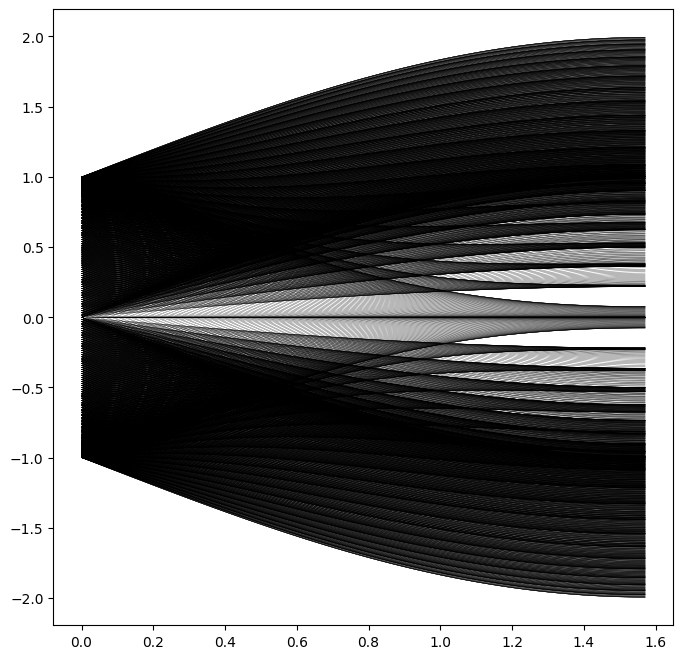

In [ ]:
fig, ax = plt.subplots(figsize=(8.0,8.0))
for n in range(100):
    ax.plot(t,Energies[:][:][n].real,'-',lw=0.2,c='black')